# prelim

In [2]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def z0_vs_deg(Z11_21, B_true, out_deg, in_deg, ax, z_option, src, use_out_deg, op='mean'):
    # null edges of Z > 0
    if z_option == ">":
        mask = (Z11_21 > 0.) & (~B_true)
        z_str = 'Z > 0'
    elif z_option == "<":
        mask = (Z11_21 < 0.) & (~B_true)
        z_str = 'Z < 0'
        Z11_21 = np.abs(Z11_21)
    elif z_option == "all":
        mask = (~B_true)
        z_str = 'Z'
    elif z_option == "abs":
        mask = (~B_true)
        z_str = '|Z|'
    else:
        raise NotImplementedError(f"{z_option}")
    
    # mean over all in edges for each source node
    if z_option == "abs":
        Z11_21 = np.abs(Z11_21)
    if src:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=1) / mask.astype(float).sum(axis=1)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=1)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "source"
    else:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=0) / mask.astype(float).sum(axis=0)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=0)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "destination"
    
    deg2n = {}
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)
    
    for deg in deg_uni:
        _mask = np.where(deg_list == deg)[0]
        if op == 'mean':
            deg2n[deg] = Z11_21[_mask].mean()
        elif op == 'max':
            deg2n[deg] = Z11_21[_mask].max()
        else:
            raise NotImplementedError(f"{op}")
        
    ax = sns.lineplot(x=deg2n.keys(), y=deg2n.values(), marker='o', ax=ax)
    ax.set_title(f'{z_str} of null edges vs {deg_str} of {src_str} nodes')

def z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=False):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"
    
    
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)

    data_dict = {
        "deg": [],
        "Z": [],
        "label": []
    }
    
    for deg in deg_uni:
        _n_mask = np.where(deg_list == deg)[0]
        n_mask = np.full(len(deg_list), fill_value=False)
        n_mask[_n_mask] = True
        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    # sns.boxplot(df, x='deg', y='Z', hue='label', ax=ax[0])
    # if use_strip:
    #     sns.stripplot(df, x='deg', y='Z', hue='label', ax=ax[0], alpha=0.7)
    # sns.boxplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1])
    # if use_strip:
    #     sns.stripplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1], alpha=0.7)
    # ax[0].set_title(f'Z vs {deg_str} of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    return df
    
def z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, ax, z_option, src, comb, op='mean'):
    # null edges of Z > 0
    if z_option == ">":
        mask = (Z11_21 > 0.) & (~B_true)
        z_str = 'Z > 0'
    elif z_option == "<":
        mask = (Z11_21 < 0.) & (~B_true)
        z_str = 'Z < 0'
        Z11_21 = np.abs(Z11_21)
    elif z_option == "all":
        mask = (~B_true)
        z_str = 'Z'
    elif z_option == "abs":
        mask = (~B_true)
        z_str = '|Z|'
    else:
        raise NotImplementedError(f"{z_option}")
    
    # mean over all in edges for each source node
    if z_option == "abs":
        Z11_21 = np.abs(Z11_21)
    if src:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=1) / mask.astype(float).sum(axis=1)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=1)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "source"
    else:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=0) / mask.astype(float).sum(axis=0)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=0)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "destination"
    
    deg2n = {}
    if comb == 'out-in':
        deg_list = out_deg - in_deg
    elif comb == 'in-out':
        deg_list = in_deg - out_deg
    elif comb == 'out+in':
        deg_list = out_deg + in_deg
    elif comb == 'out*in':
        deg_list = out_deg * in_deg
    elif comb == 'out/in':
        deg_list = out_deg / (in_deg+1)
    elif comb == 'in/out':
        deg_list = in_deg / (out_deg+1)
    deg_uni = np.unique(deg_list)
    
    for deg in deg_uni:
        _mask = np.where(deg_list == deg)[0]
        if op == 'mean':
            deg2n[deg] = Z11_21[_mask].mean()
        elif op == 'max':
            deg2n[deg] = Z11_21[_mask].max()
        else:
            raise NotImplementedError(f"{op}")
        
    ax = sns.lineplot(x=deg2n.keys(), y=deg2n.values(), marker='o', ax=ax)
    ax.set_title(f'{z_str} of null edges vs {comb} deg of {src_str} nodes')

In [175]:
n_nodes = 80
X, B_true, W_est, W_true = load_data(n_nodes, 1, "v34/v80")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

# Z null vs out-deg of source nodes

In [327]:
in_deg, out_deg

(array([ 2,  4,  2,  1,  5,  6,  3,  1,  3,  5,  0,  0,  4,  3,  7,  0,  8,
         4,  3,  3,  3,  0,  7,  0,  1,  0,  9,  2,  5,  6,  3,  4,  0,  2,
         0,  5,  1,  7, 11,  4,  2, 12,  4,  3,  7,  5,  1,  8,  5,  6,  3,
         6,  1,  7,  2,  0,  0, 10, 11,  9,  5,  5,  2,  8,  3,  0,  7,  9,
         4,  6,  5,  0,  0,  7,  9,  6,  2,  3,  2,  1]),
 array([ 6,  1, 15,  4,  4,  3,  4,  7, 10,  4,  7,  8,  7,  6,  0,  3,  1,
         3,  6,  3,  4,  6,  0,  4,  4,  5,  1,  7,  0,  2,  1,  0,  6,  1,
         8,  0,  6,  3,  0,  6,  3,  0,  6,  6,  2,  4, 10,  4,  1,  5,  4,
         4,  8,  0,  4,  4,  4,  1,  0,  5,  0,  0,  8,  1,  9,  7,  0,  1,
         3,  5,  8,  9,  2,  3,  1,  1,  6,  2,  3, 10]))

Text(0, 0.5, 'out degree')

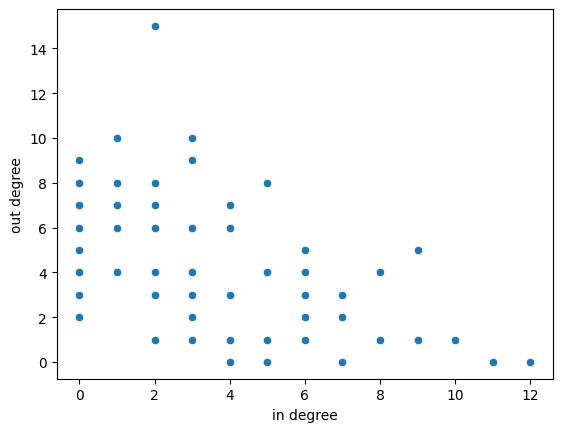

In [330]:
ax = sns.scatterplot(x=in_deg, y=out_deg)
ax.set_xlabel('in degree')
ax.set_ylabel('out degree')

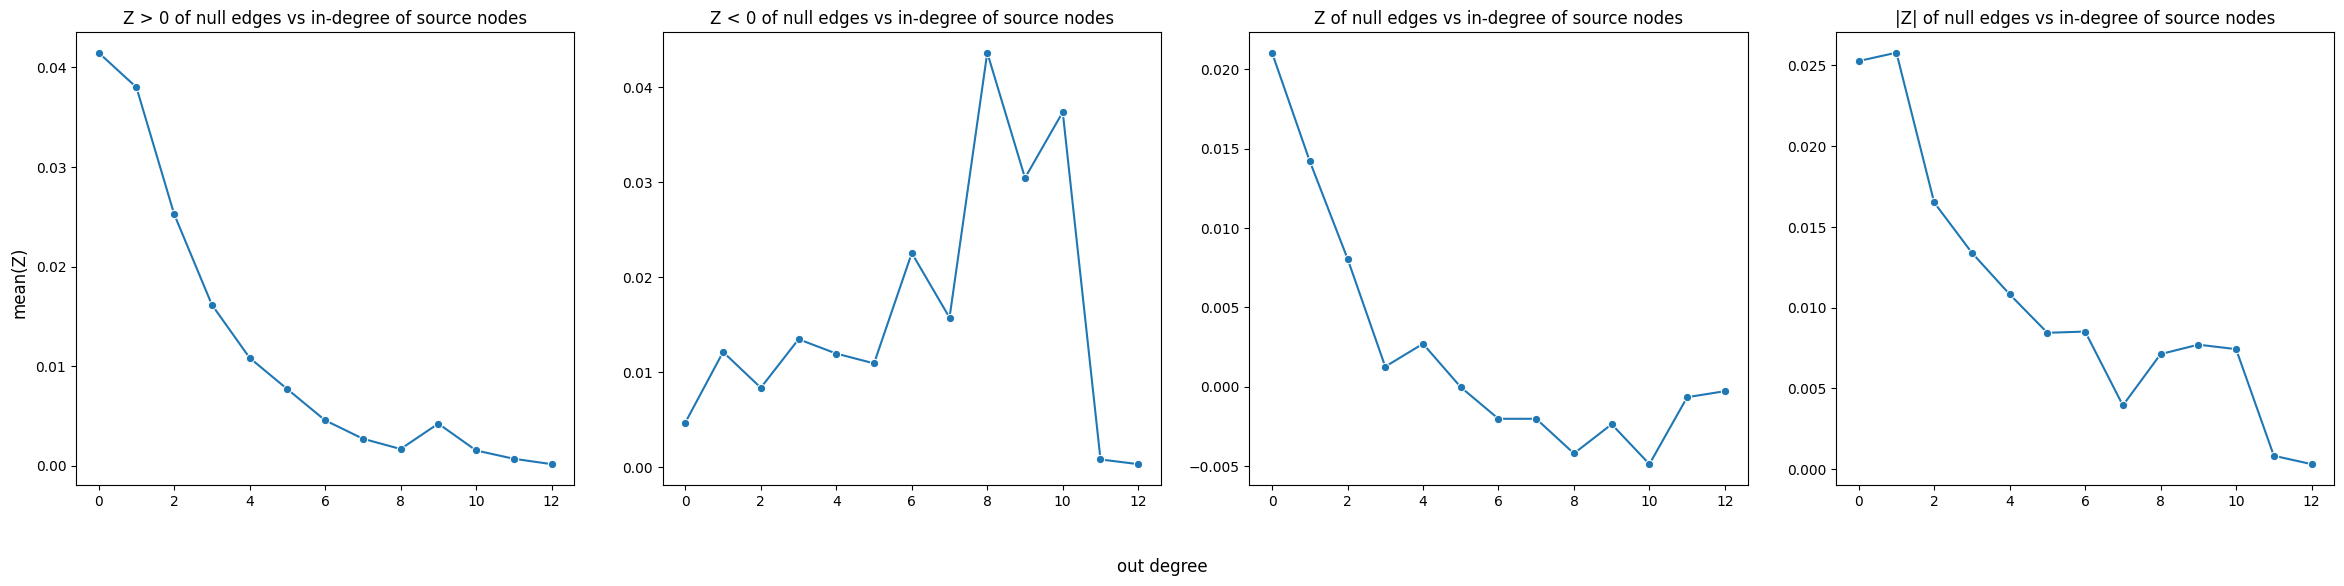

In [301]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
use_out_degree=True

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=True, use_out_deg=False)    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

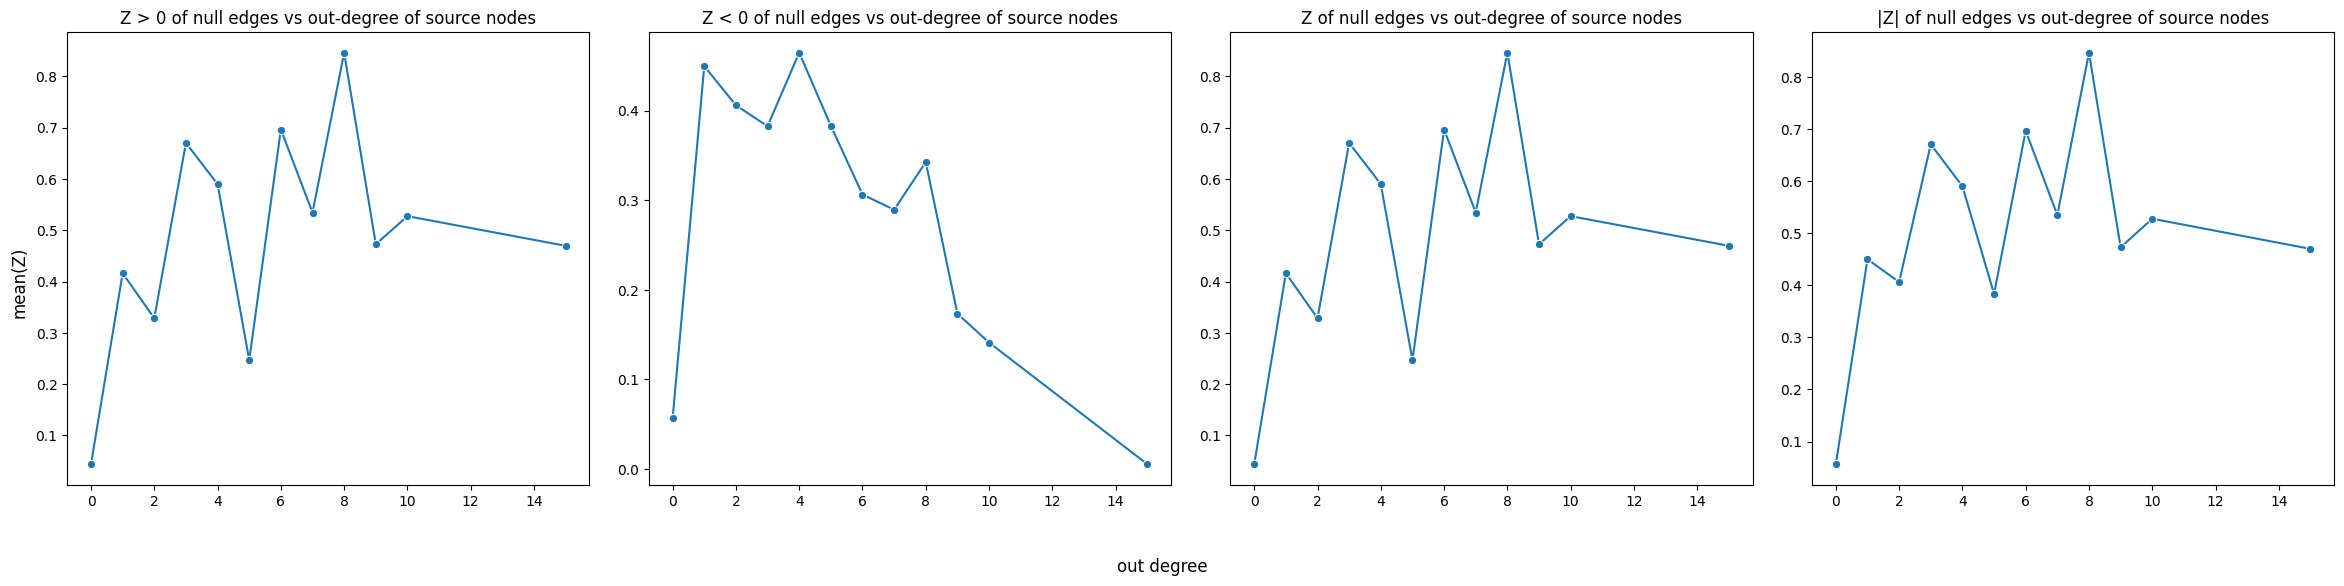

In [302]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
use_out_degree=True

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, use_out_deg=use_out_degree, op='max')    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

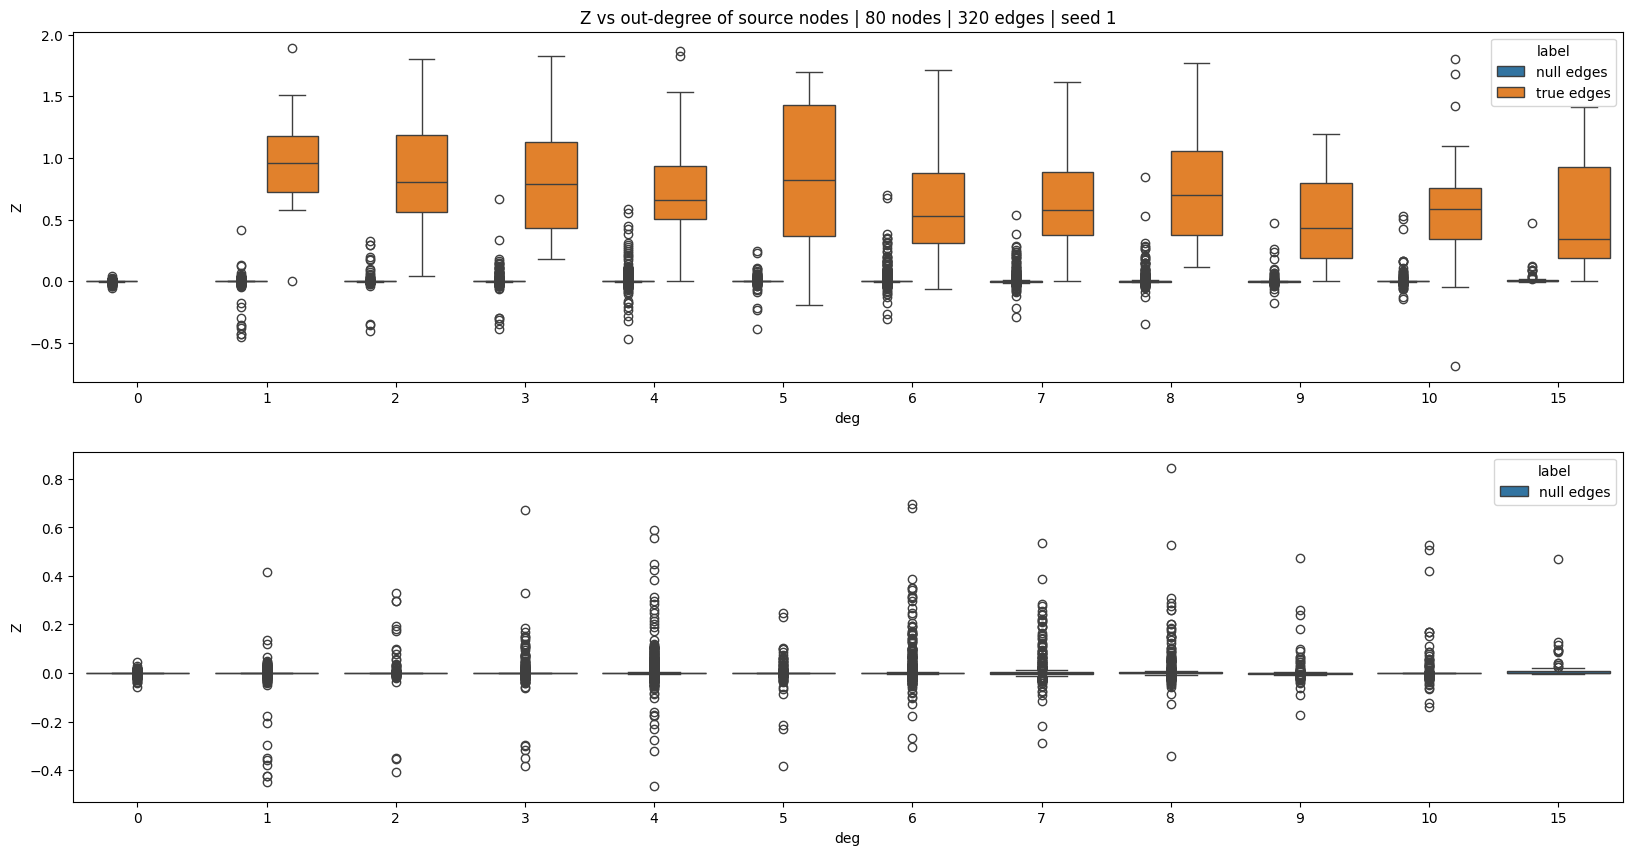

In [320]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=True)

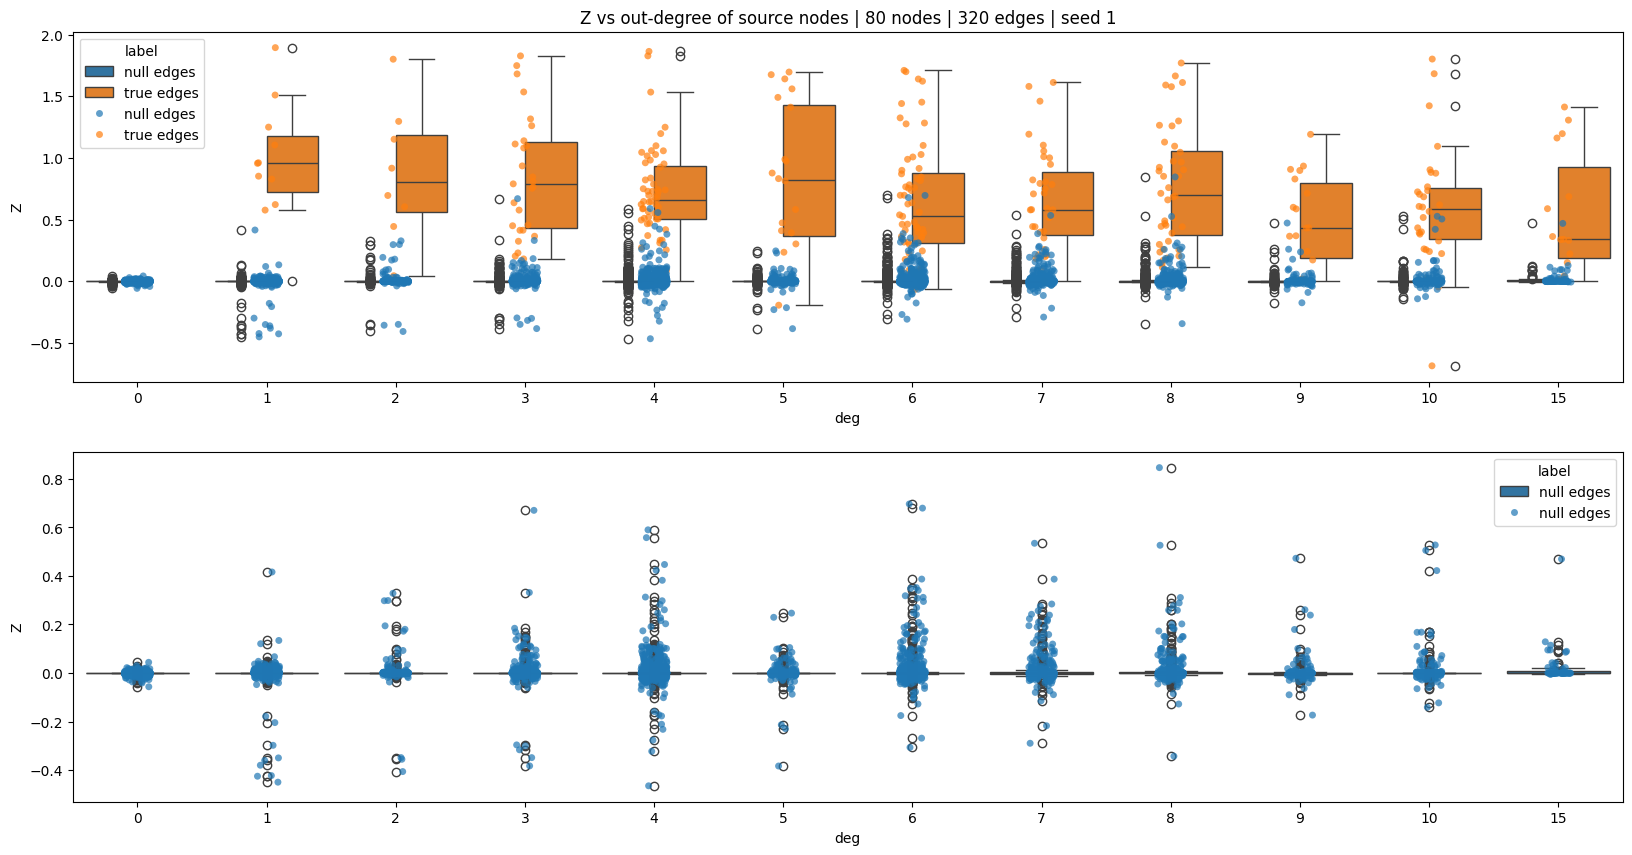

In [325]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=True, use_strip=True)

In [332]:
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=True)

In [342]:
np.quantile(df.loc[(df.deg == 0) & (df.label == 'null edges')].Z.values, q=0)

-0.08717066325097603

In [344]:
np.quantile(df.loc[(df.deg == 0) & (df.label == 'null edges')].Z.values, q=0.5)

6.438980822299401e-06

In [345]:
np.quantile(df.loc[(df.deg == 0) & (df.label == 'null edges')].Z.values, q=0.25)

-0.00019127941428803303

In [346]:
np.quantile(df.loc[(df.deg == 0) & (df.label == 'null edges')].Z.values, q=0.75)

0.006829210491884734

In [347]:
np.quantile(df.loc[(df.deg == 0) & (df.label == 'null edges')].Z.values, q=1)

0.8463352658805752

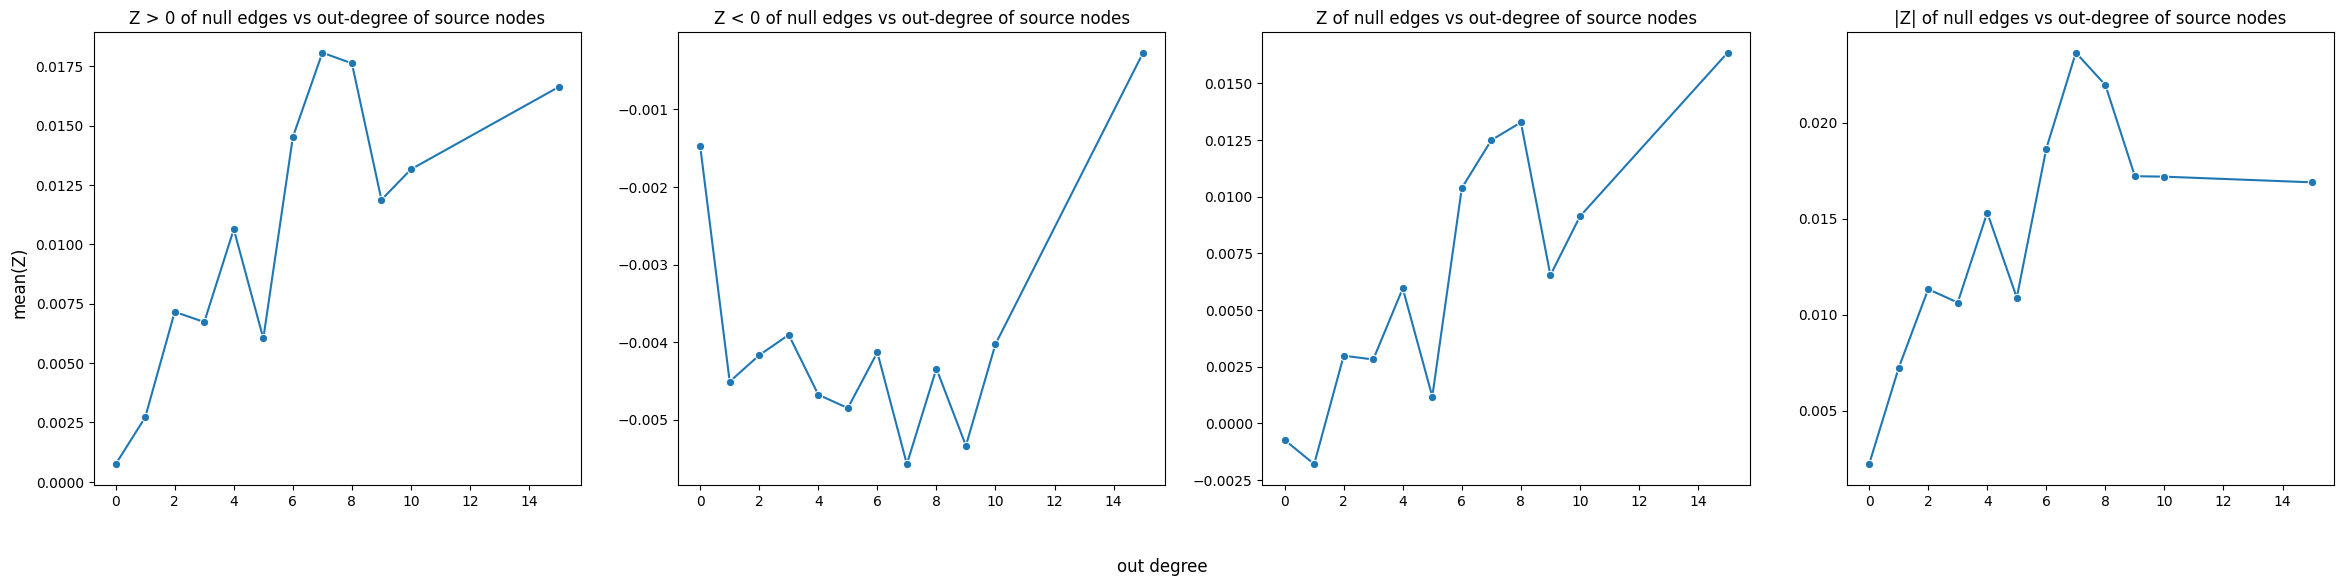

In [102]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

""" Z null > 0 vs out_deg of source_nodes"""

# null edges of Z > 0
mask = (Z11_21 > 0.) & (~B_true)

# Z(null) > 0, mean over all in edges for each source node
Z11_21_src = (Z11_21 * mask.astype(float)).sum(axis=1)

deg2src = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[0])
ax.set_title('Z > 0 of null edges vs out-degree of source nodes')

""" Z null < 0 vs out_deg of source_nodes"""

# null edges of Z < 0
mask = (Z11_21 < 0.) & (~B_true)

# Z(null) < 0, mean over all in edges for each source node
Z11_21_src = (Z11_21 * mask.astype(float)).mean(axis=1)

deg2src = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[1])
ax.set_title('Z < 0 of null edges vs out-degree of source nodes')

""" Z null vs out_deg of source_nodes"""

# null edges of Z < 0
mask = (~B_true)

# Z(null) mean over all in edges for each source node
Z11_21_src = (Z11_21 * mask.astype(float)).mean(axis=1)

deg2src = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[2])
ax.set_title('Z of null edges vs out-degree of source nodes')

""" |Z| null vs out_deg of source_nodes"""

# null edges of Z < 0
mask = (~B_true)

# Z(null) mean over all in edges for each source node
Z11_21_src = (np.abs(Z11_21) * mask.astype(float)).mean(axis=1)

deg2src = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[3])
ax.set_title('|Z| of null edges vs out-degree of source nodes')


fig.supxlabel('out degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

plt.show()

# Z null vs in-deg of source nodes

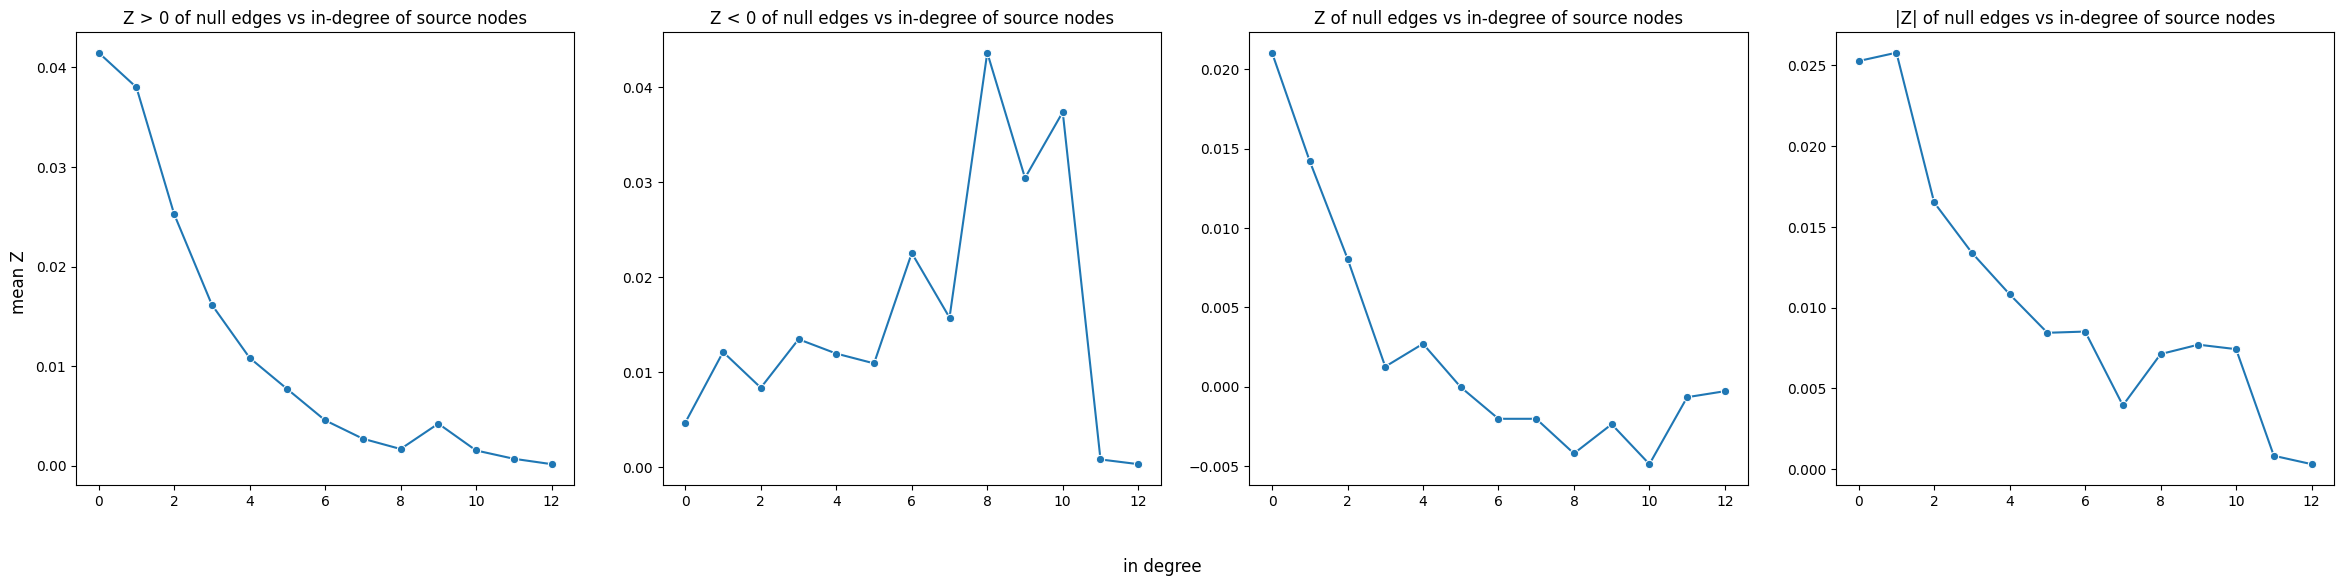

In [251]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
use_out_degree=False
op='mean'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, use_out_deg=use_out_degree, op=op)    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel(f'{op} Z')
plt.tight_layout(pad=2)

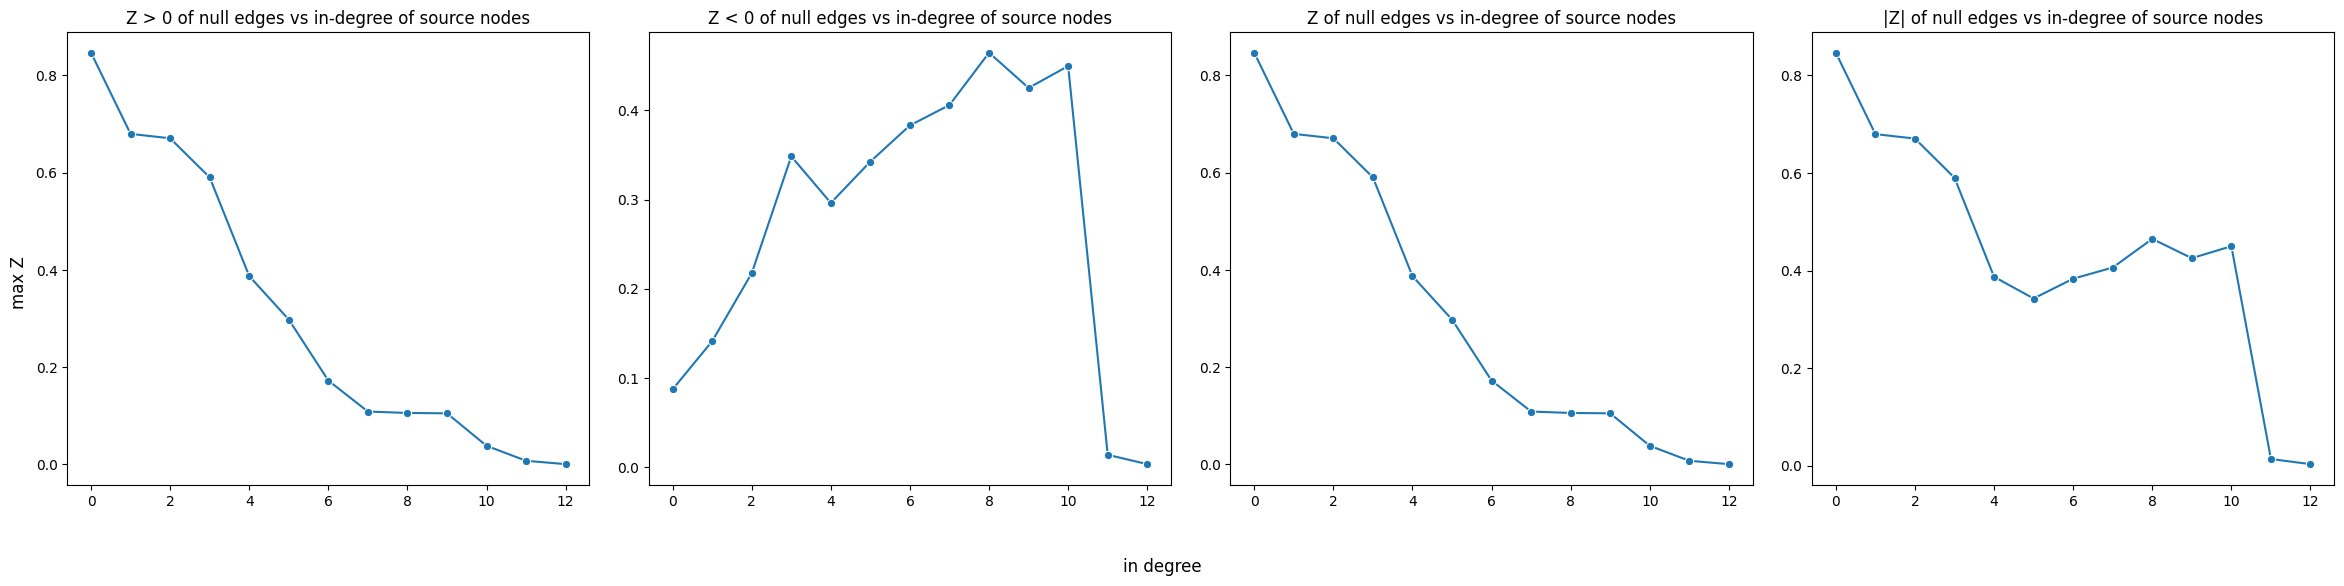

In [196]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
use_out_degree=False
op='max'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, use_out_deg=use_out_degree, op=op)    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel(f'{op} Z')
plt.tight_layout(pad=2)

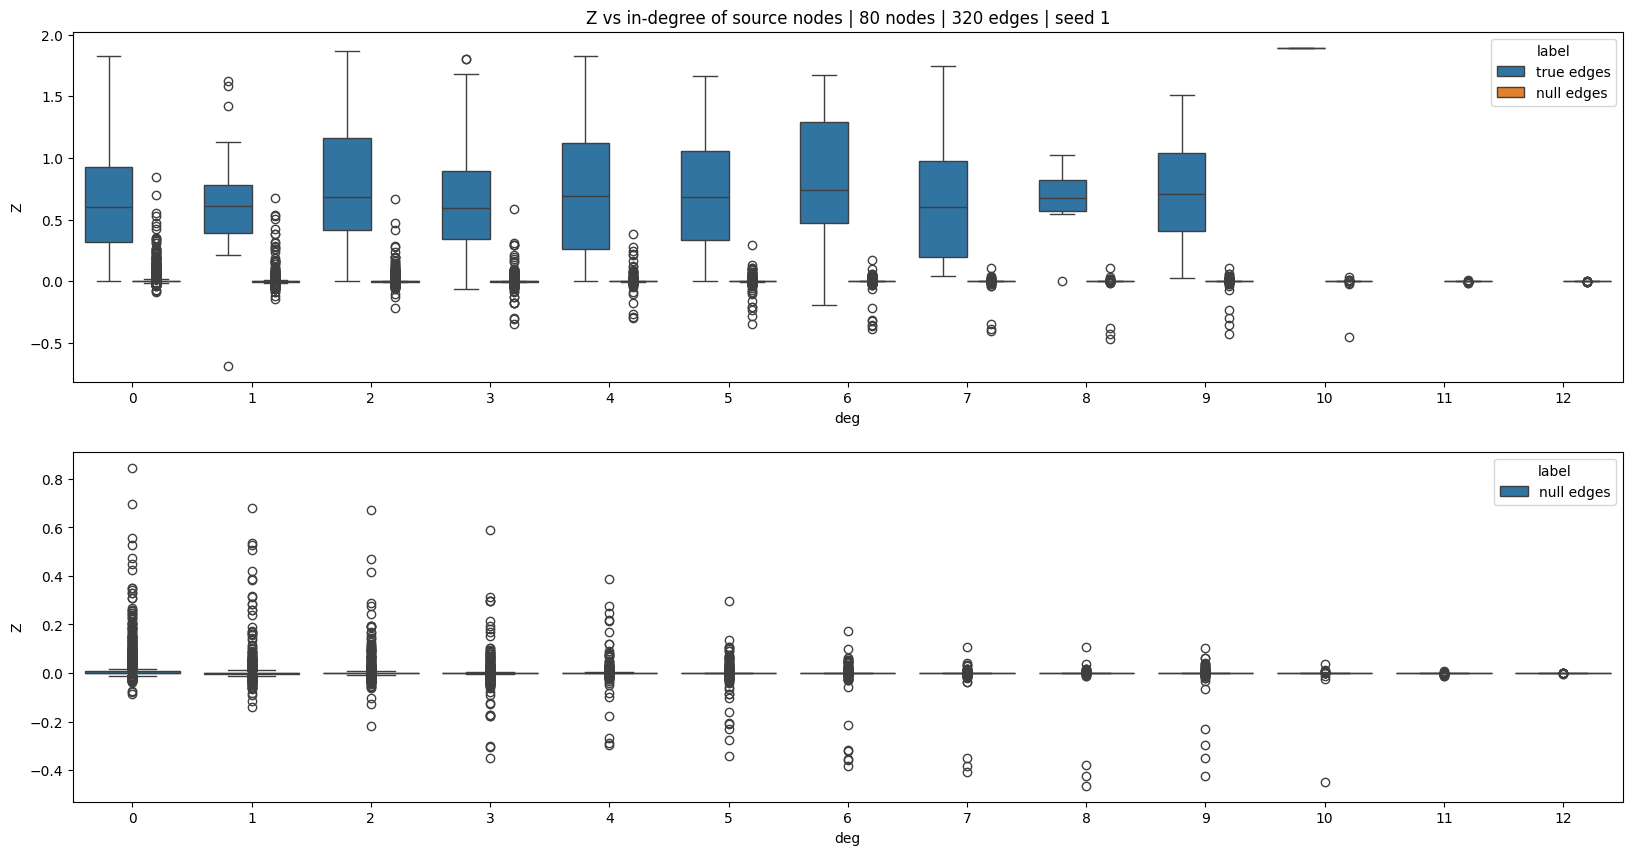

In [321]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False)

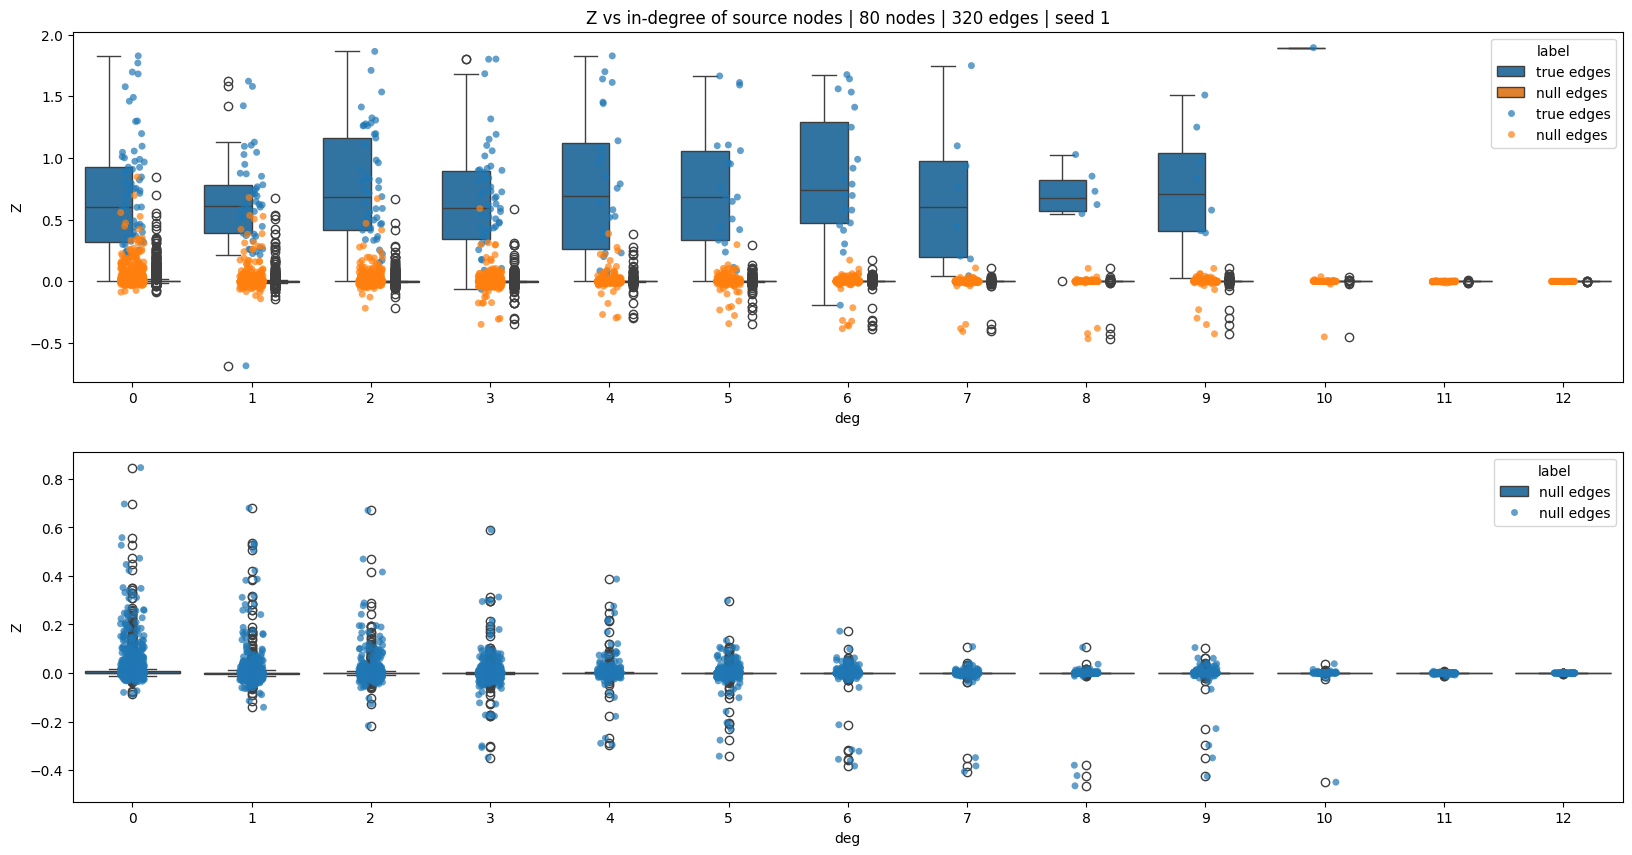

In [326]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=True)

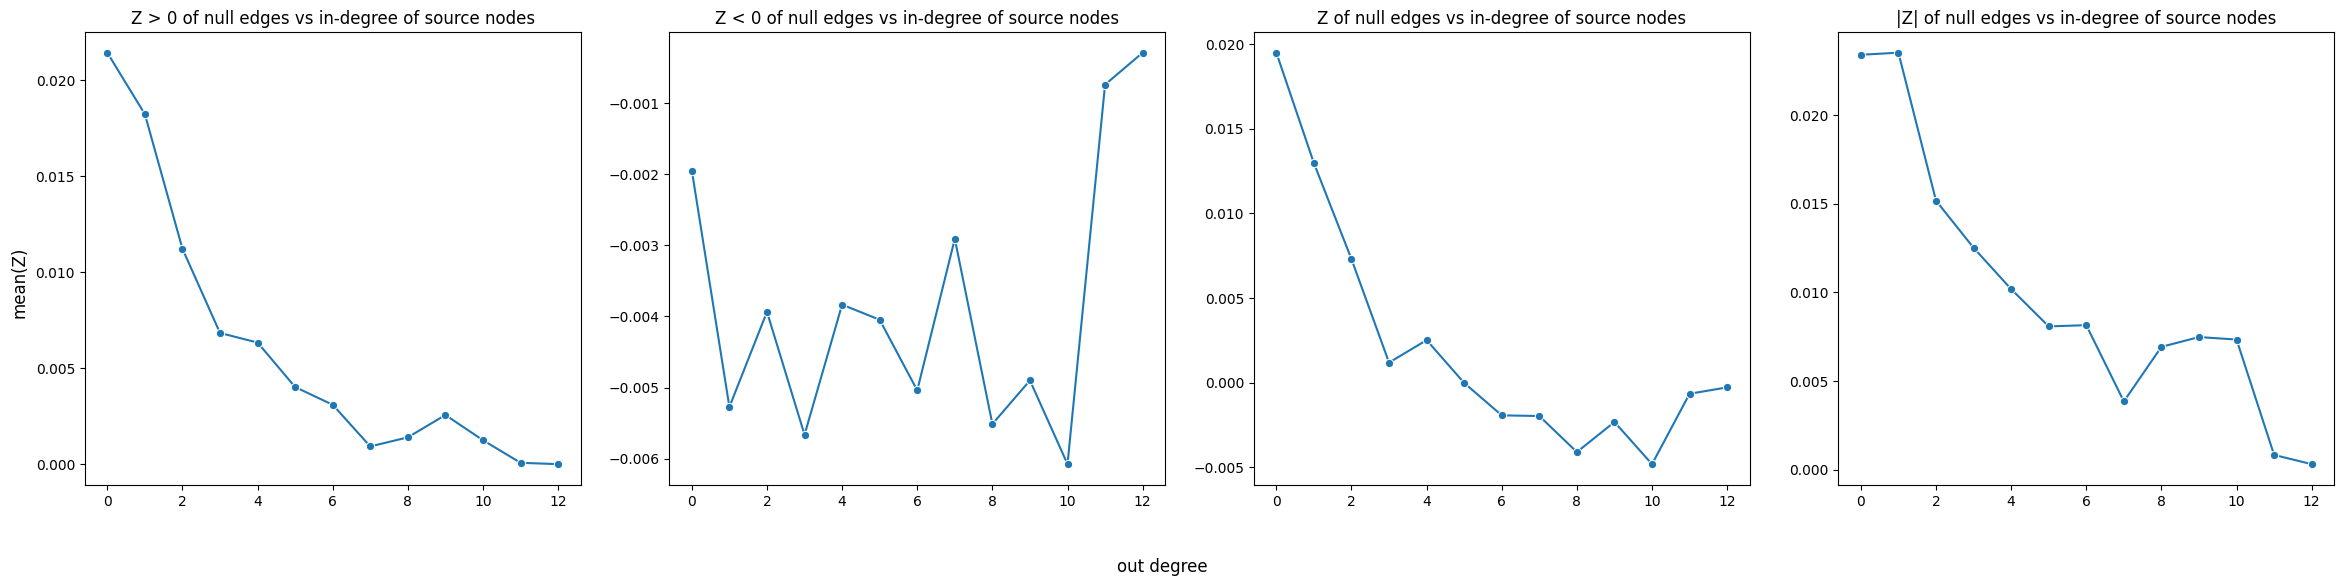

In [103]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

""" Z null > 0 vs in_deg of source_nodes"""

# null edges of Z > 0
mask = (Z11_21 > 0.) & (~B_true)

# Z(null) > 0, mean over all in edges for each source node
Z11_21_src = (Z11_21 * mask.astype(float)).mean(axis=1)

deg2src = {}
in_deg_uni = np.unique(in_deg)
for deg in in_deg_uni:
    _mask = np.where(in_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[0])
ax.set_title('Z > 0 of null edges vs in-degree of source nodes')

""" Z null < 0 vs in_deg of source_nodes"""

# null edges of Z < 0
mask = (Z11_21 < 0.) & (~B_true)

# Z(null) < 0, mean over all in edges for each source node
Z11_21_src = (Z11_21 * mask.astype(float)).mean(axis=1)

deg2src = {}
in_deg_uni = np.unique(in_deg)
for deg in in_deg_uni:
    _mask = np.where(in_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[1])
ax.set_title('Z < 0 of null edges vs in-degree of source nodes')

""" Z null vs in_deg of source_nodes"""

# null edges of Z < 0
mask = (~B_true)

# Z(null) mean over all in edges for each source node
Z11_21_src = (Z11_21 * mask.astype(float)).mean(axis=1)

deg2src = {}
in_deg_uni = np.unique(in_deg)
for deg in in_deg_uni:
    _mask = np.where(in_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[2])
ax.set_title('Z of null edges vs in-degree of source nodes')

""" |Z| null vs in_deg of source_nodes"""

# null edges of Z < 0
mask = (~B_true)

# Z(null) mean over all in edges for each source node
Z11_21_src = (np.abs(Z11_21) * mask.astype(float)).mean(axis=1)

deg2src = {}
in_deg_uni = np.unique(in_deg)
for deg in in_deg_uni:
    _mask = np.where(in_deg == deg)[0]
    deg2src[deg] = Z11_21_src[_mask].mean()

ax = sns.lineplot(x=deg2src.keys(), y=deg2src.values(), marker='o', ax=axs[3])
ax.set_title('|Z| of null edges vs in-degree of source nodes')

fig.supxlabel('out degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

plt.show()

# Z null vs out-deg of dst nodes

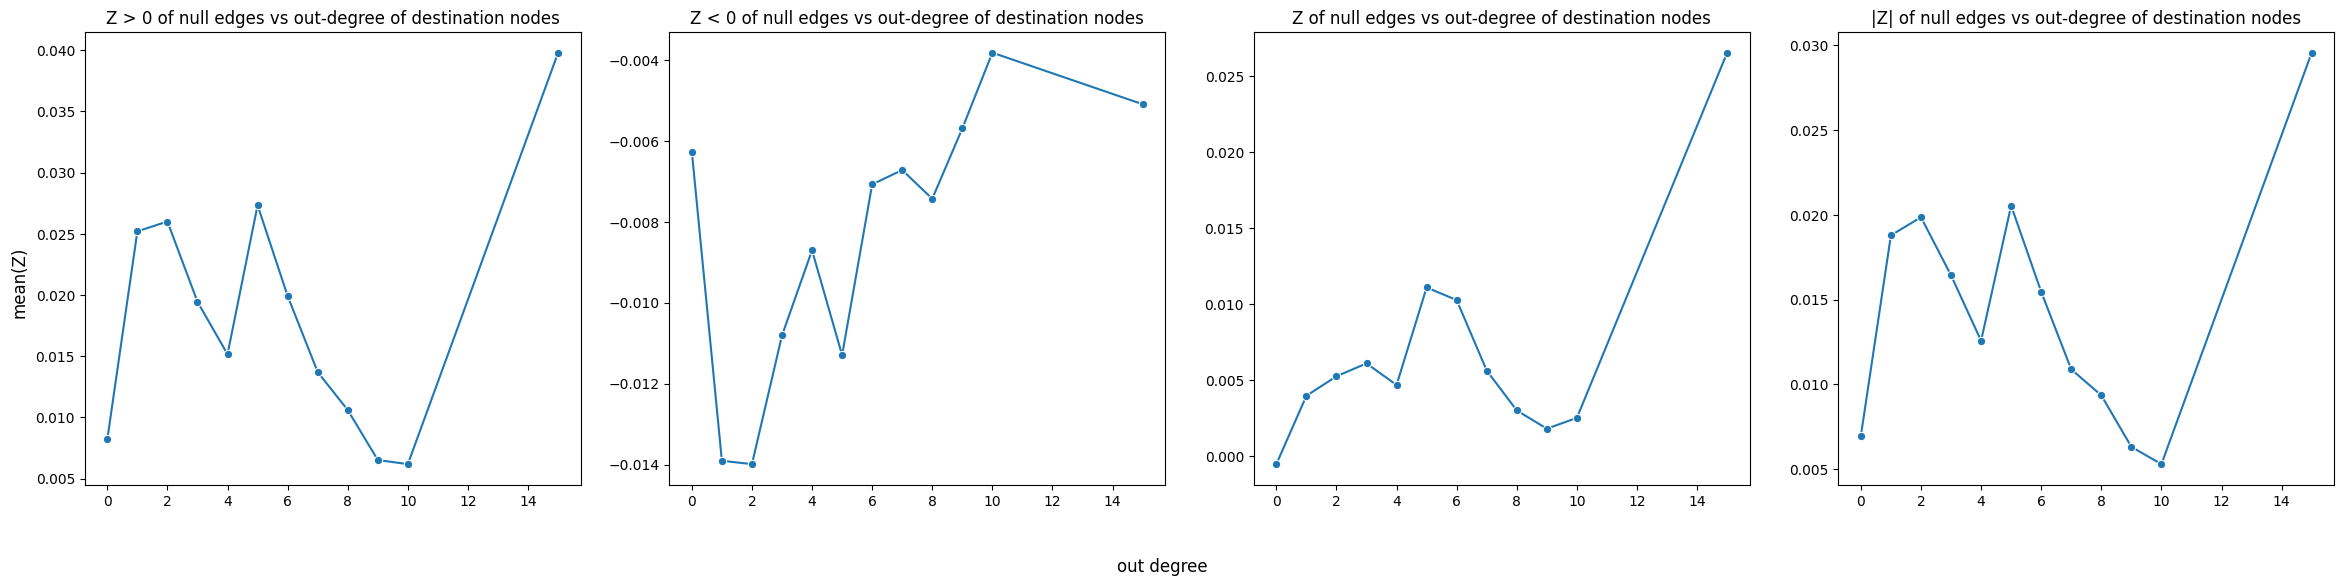

In [138]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=False
use_out_degree=True

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, use_out_deg=use_out_degree)    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

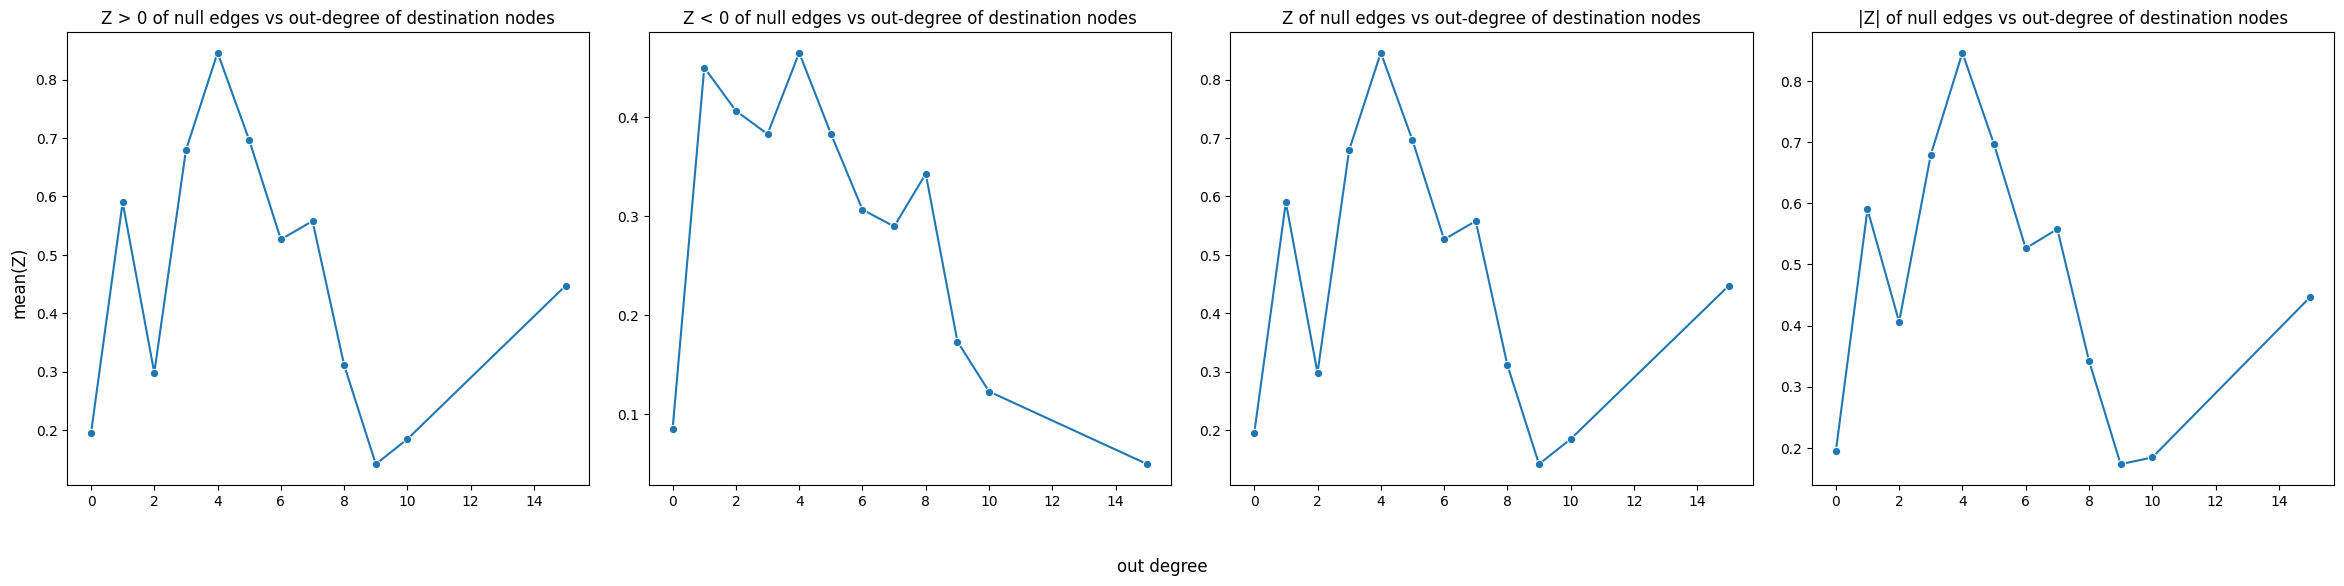

In [188]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=False
use_out_degree=True

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, use_out_deg=use_out_degree, op='max')    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

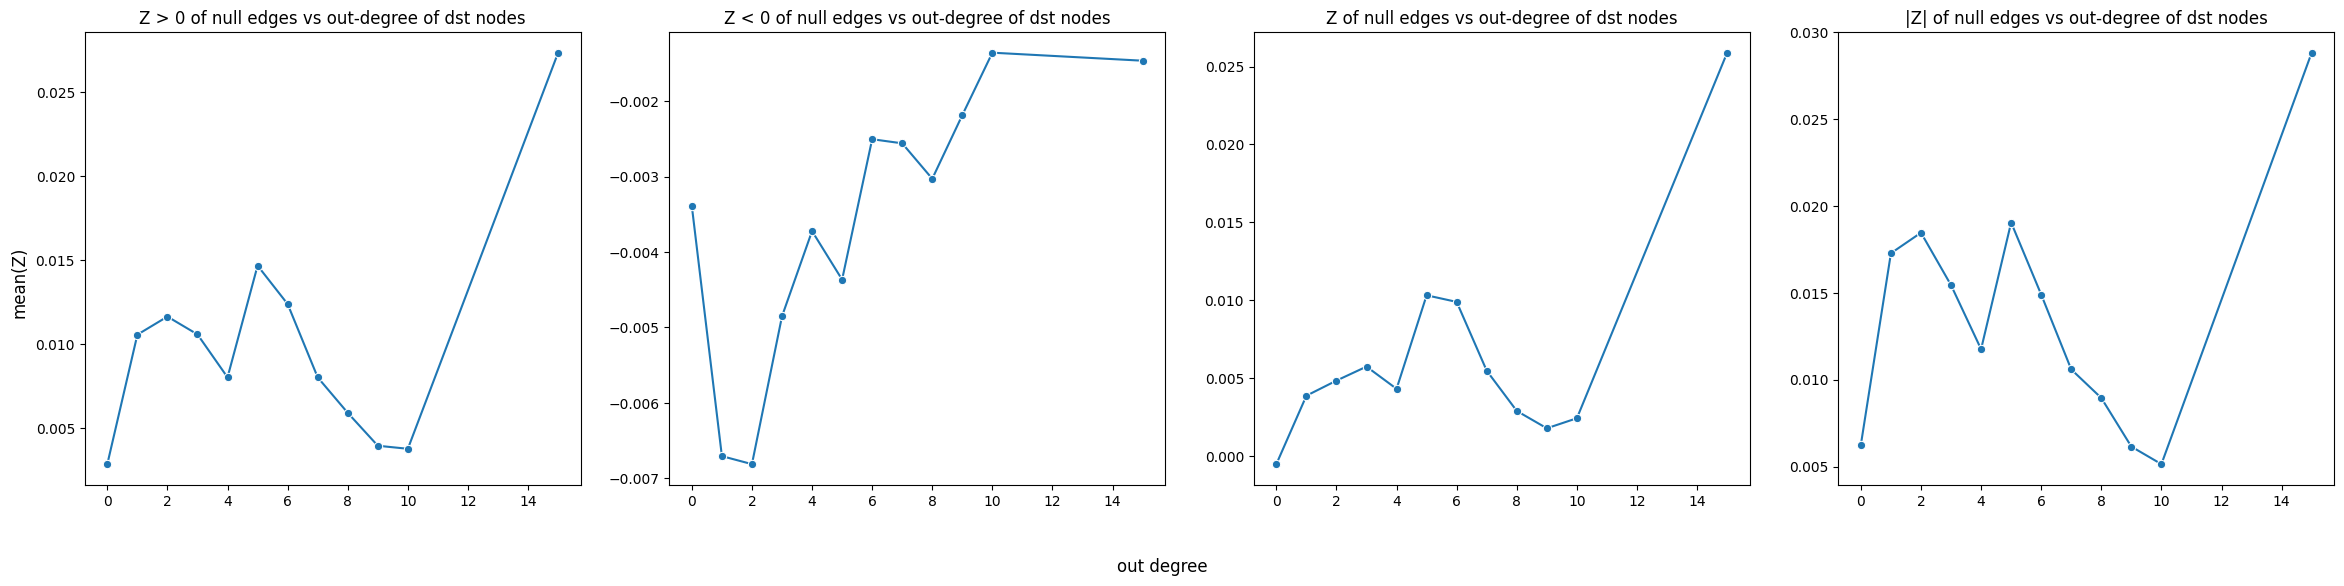

In [105]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

""" Z null > 0 vs out_deg of dst nodes"""

# null edges of Z > 0
mask = (Z11_21 > 0.) & (~B_true)

# Z(null) > 0, mean over all in edges for each dst node
Z11_21_dst = (Z11_21 * mask.astype(float)).mean(axis=0)

deg2dst = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2dst[deg] = Z11_21_dst[_mask].mean()

ax = sns.lineplot(x=deg2dst.keys(), y=deg2dst.values(), marker='o', ax=axs[0])
ax.set_title('Z > 0 of null edges vs out-degree of dst nodes')

""" Z null < 0 vs out_deg of dst_nodes"""

# null edges of Z < 0
mask = (Z11_21 < 0.) & (~B_true)

# Z(null) < 0, mean over all in edges for each dst node
Z11_21_dst = (Z11_21 * mask.astype(float)).mean(axis=0)

deg2dst = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2dst[deg] = Z11_21_dst[_mask].mean()

ax = sns.lineplot(x=deg2dst.keys(), y=deg2dst.values(), marker='o', ax=axs[1])
ax.set_title('Z < 0 of null edges vs out-degree of dst nodes')

""" Z null vs out_deg of dst_nodes"""

# null edges of Z < 0
mask = (~B_true)

# Z(null) mean over all in edges for each dst node
Z11_21_dst = (Z11_21 * mask.astype(float)).mean(axis=0)

deg2dst = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2dst[deg] = Z11_21_dst[_mask].mean()

ax = sns.lineplot(x=deg2dst.keys(), y=deg2dst.values(), marker='o', ax=axs[2])
ax.set_title('Z of null edges vs out-degree of dst nodes')

""" |Z| null vs out_deg of dst_nodes"""

# null edges of Z < 0
mask = (~B_true)

# Z(null) mean over all in edges for each dst node
Z11_21_dst = (np.abs(Z11_21) * mask.astype(float)).mean(axis=0)

deg2dst = {}
out_deg_uni = np.unique(out_deg)
for deg in out_deg_uni:
    _mask = np.where(out_deg == deg)[0]
    deg2dst[deg] = Z11_21_dst[_mask].mean()

ax = sns.lineplot(x=deg2dst.keys(), y=deg2dst.values(), marker='o', ax=axs[3])
ax.set_title('|Z| of null edges vs out-degree of dst nodes')


fig.supxlabel('out degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

plt.show()

# Z null vs in-deg of dst nodes

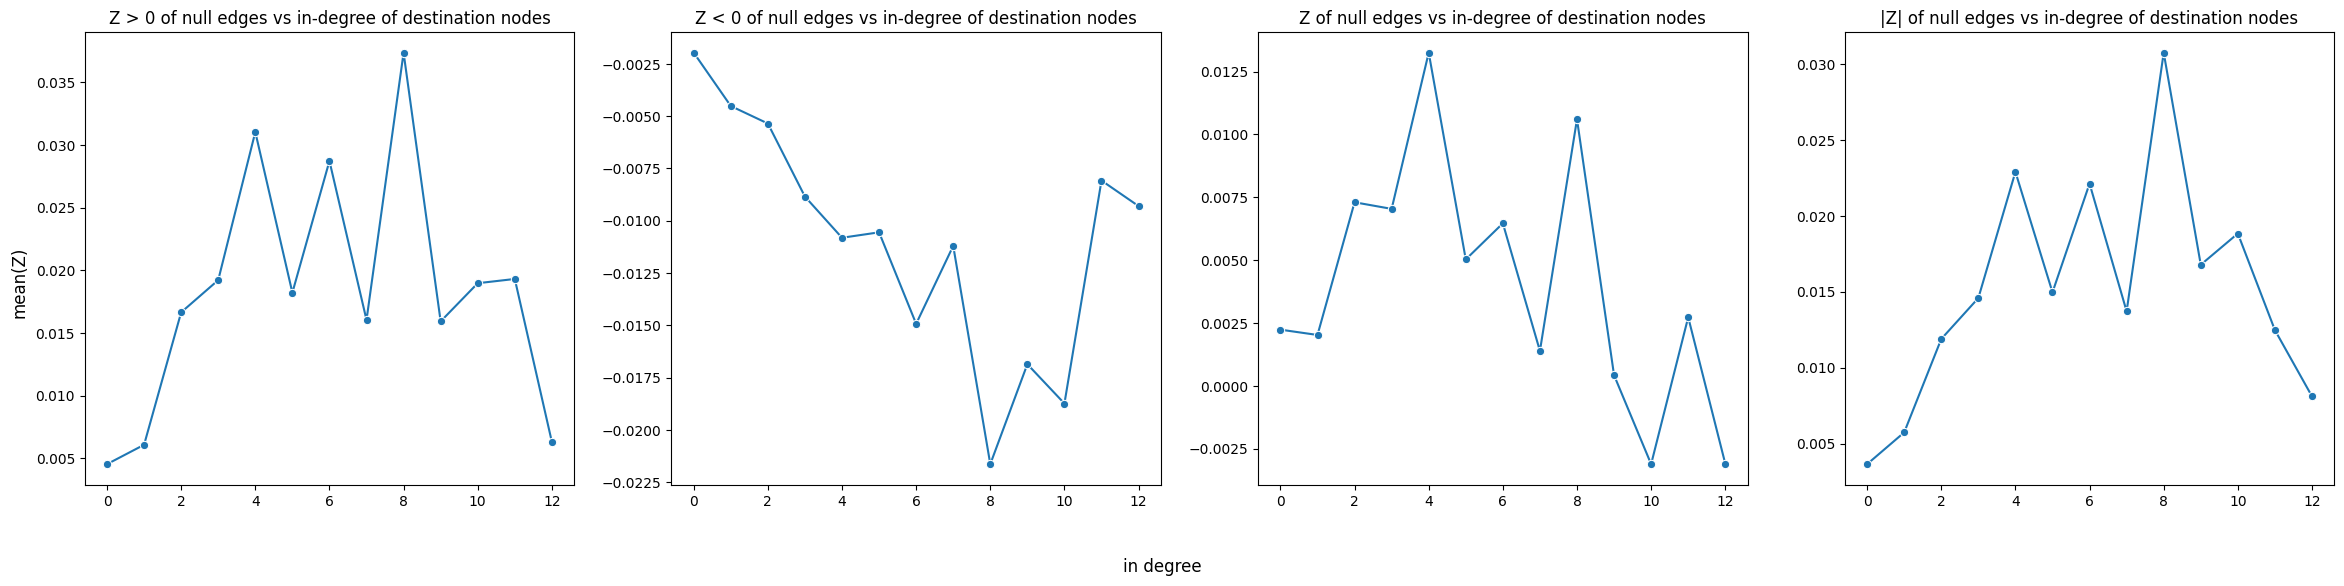

In [139]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=False
use_out_degree=False

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, use_out_deg=use_out_degree)    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

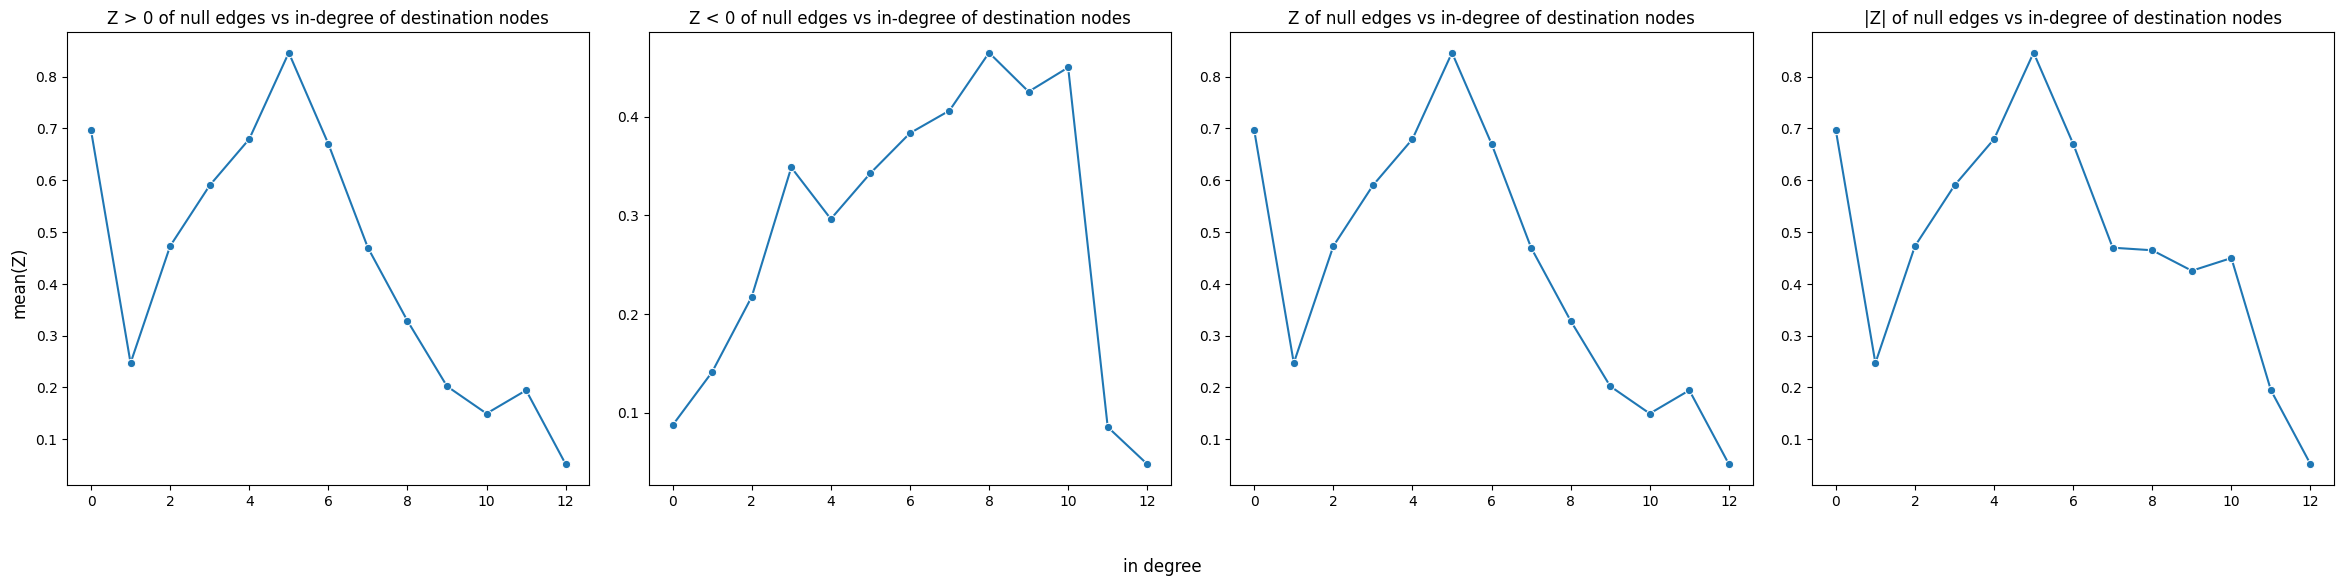

In [189]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=False
use_out_degree=False

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, use_out_deg=use_out_degree, op='max')    

if use_out_degree:
    fig.supxlabel('out degree')
else:
    fig.supxlabel('in degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

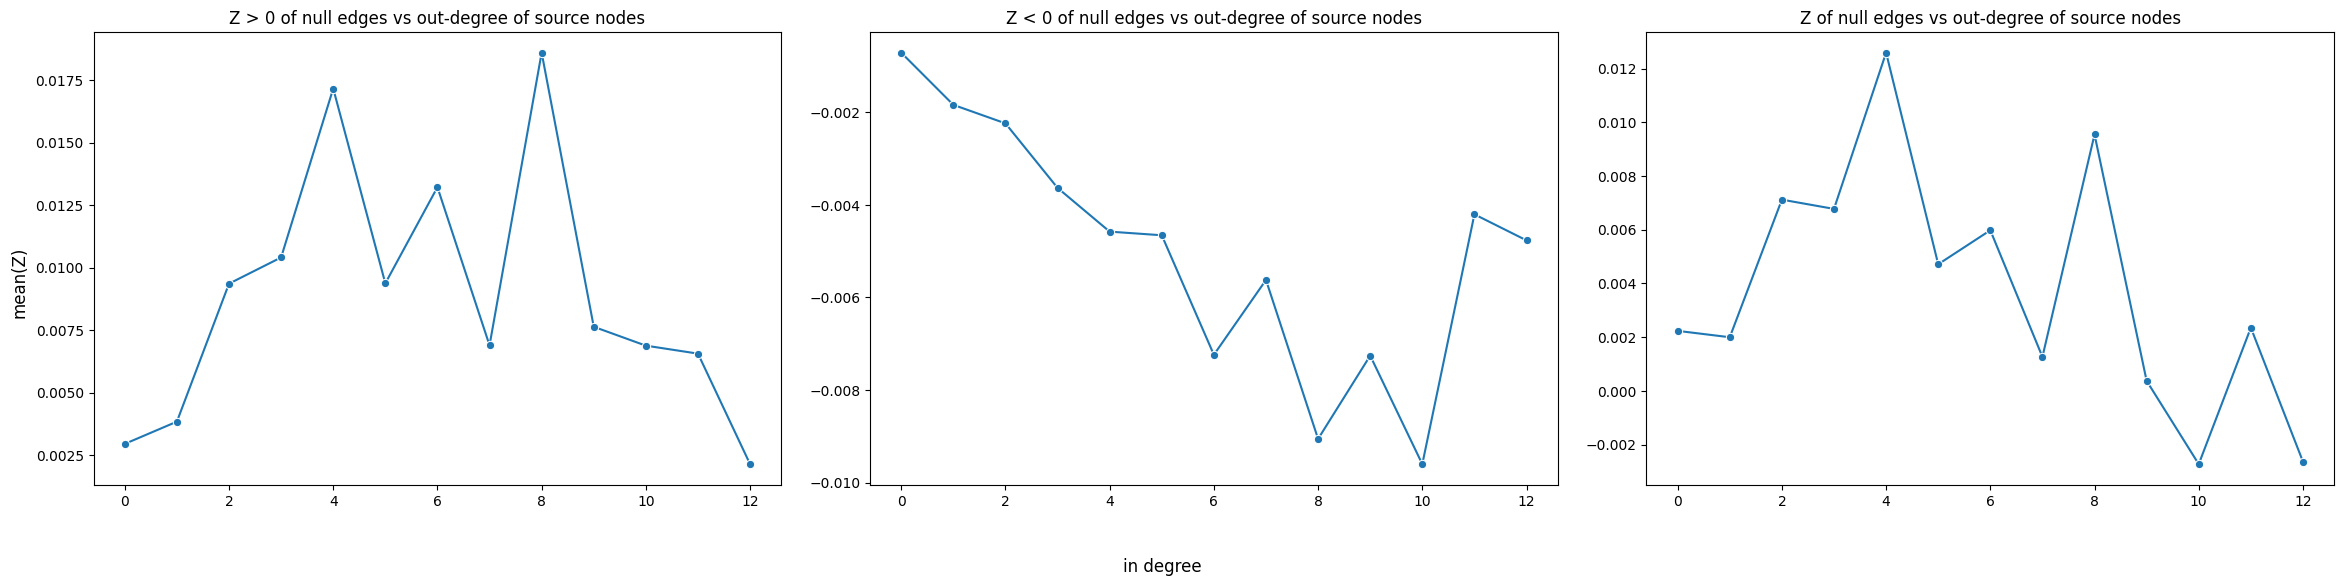

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

""" Z null > 0 vs in_deg of dst nodes"""

# null edges of Z > 0
mask = (Z11_21 > 0.) & (~B_true)

# Z(null) > 0, mean over all in edges for each source node
Z11_21_dst = (Z11_21 * mask.astype(float)).mean(axis=0)

deg2dst = {}
in_deg_uni = np.unique(in_deg)
for deg in in_deg_uni:
    _mask = np.where(in_deg == deg)[0]
    deg2dst[deg] = Z11_21_dst[_mask].mean()

ax = sns.lineplot(x=deg2dst.keys(), y=deg2dst.values(), marker='o', ax=axs[0])
ax.set_title('Z > 0 of null edges vs out-degree of source nodes')

""" Z null < 0 vs in_deg of source_nodes"""

# null edges of Z < 0
mask = (Z11_21 < 0.) & (~B_true)

# Z(null) < 0, mean over all in edges for each source node
Z11_21_dst = (Z11_21 * mask.astype(float)).mean(axis=0)

deg2dst = {}
in_deg_uni = np.unique(in_deg)
for deg in in_deg_uni:
    _mask = np.where(in_deg == deg)[0]
    deg2dst[deg] = Z11_21_dst[_mask].mean()

ax = sns.lineplot(x=deg2dst.keys(), y=deg2dst.values(), marker='o', ax=axs[1])
ax.set_title('Z < 0 of null edges vs out-degree of source nodes')

""" Z null vs in_deg of source_nodes"""

# null edges of Z < 0
mask = (~B_true)

# Z(null) mean over all in edges for each source node
Z11_21_dst = (Z11_21 * mask.astype(float)).mean(axis=0)

deg2dst = {}
in_deg_uni = np.unique(in_deg)
for deg in in_deg_uni:
    _mask = np.where(in_deg == deg)[0]
    deg2dst[deg] = Z11_21_dst[_mask].mean()

ax = sns.lineplot(x=deg2dst.keys(), y=deg2dst.values(), marker='o', ax=axs[2])
ax.set_title('Z of null edges vs out-degree of source nodes')


fig.supxlabel('in degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

plt.show()

# mean(Z_null) vs combine(out-deg, in-deg) of source nodes

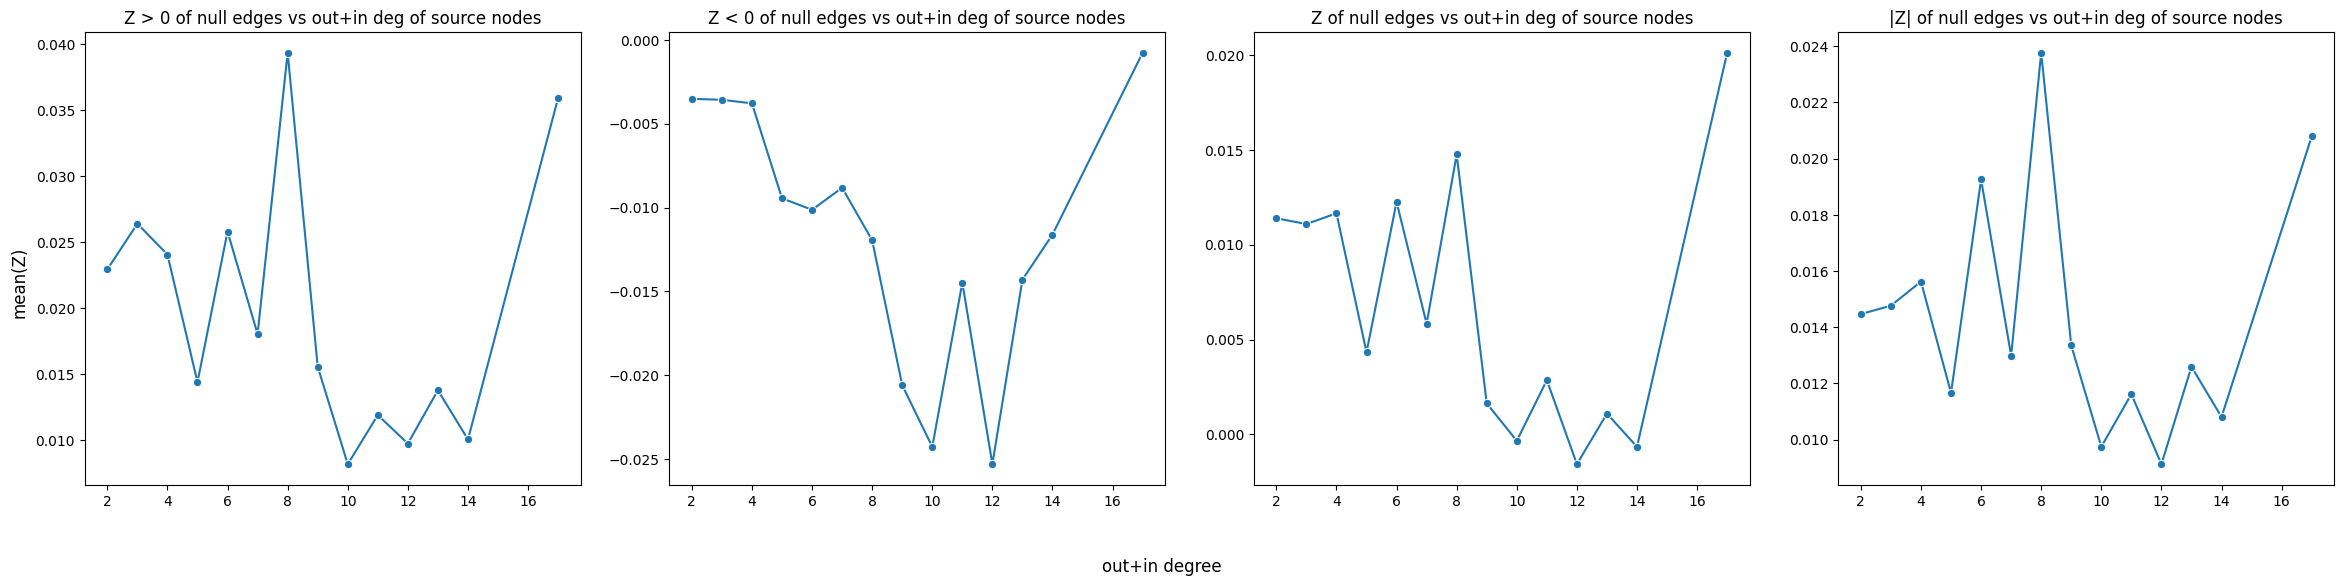

In [156]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
comb='out+in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb)    


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

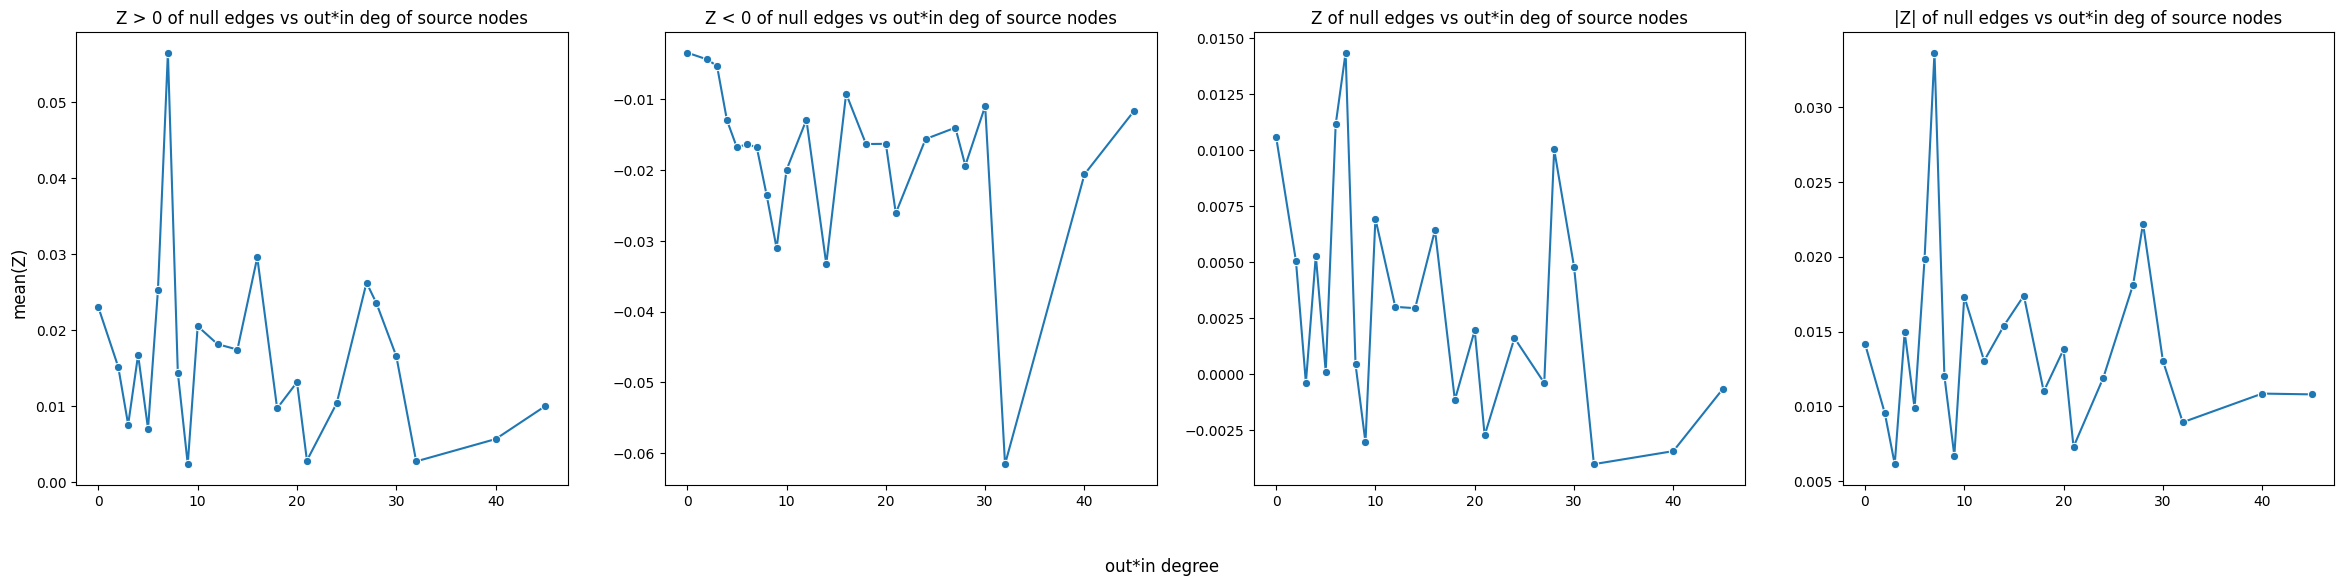

In [158]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
comb='out*in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb)    


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

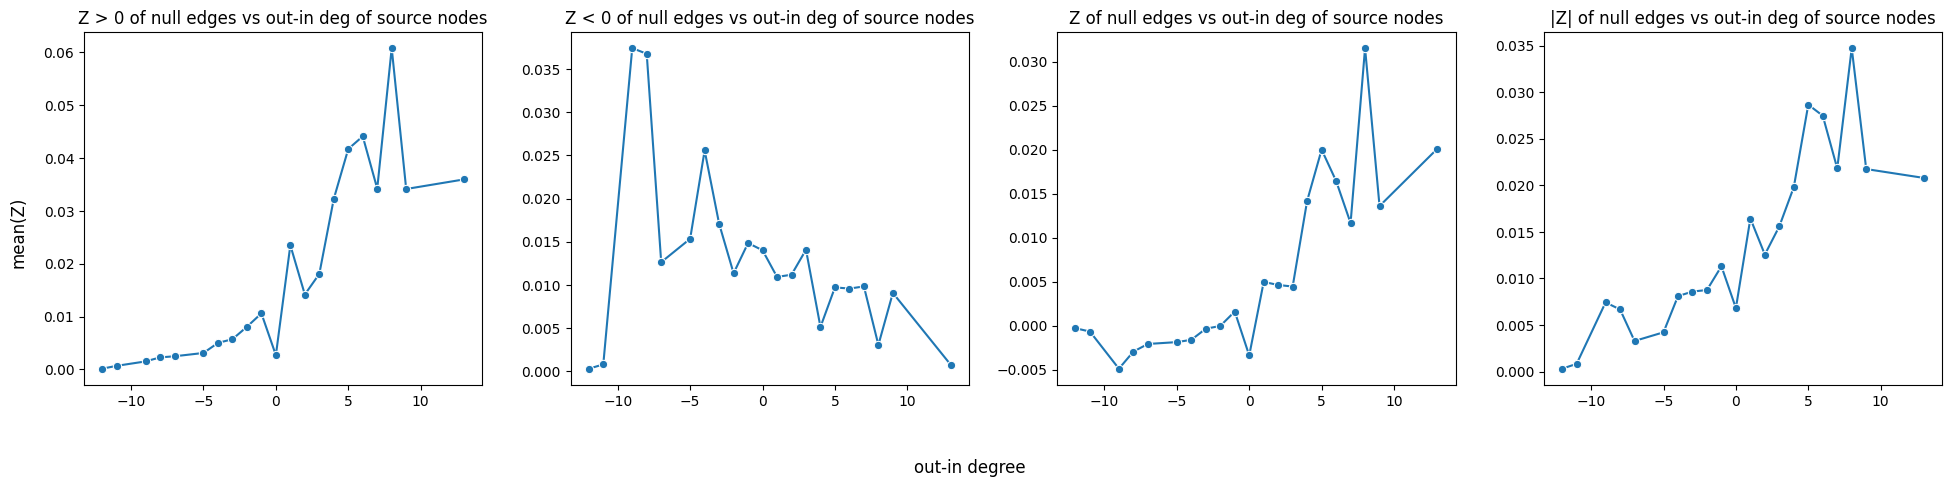

In [197]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
src=True
comb='out-in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb)    


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

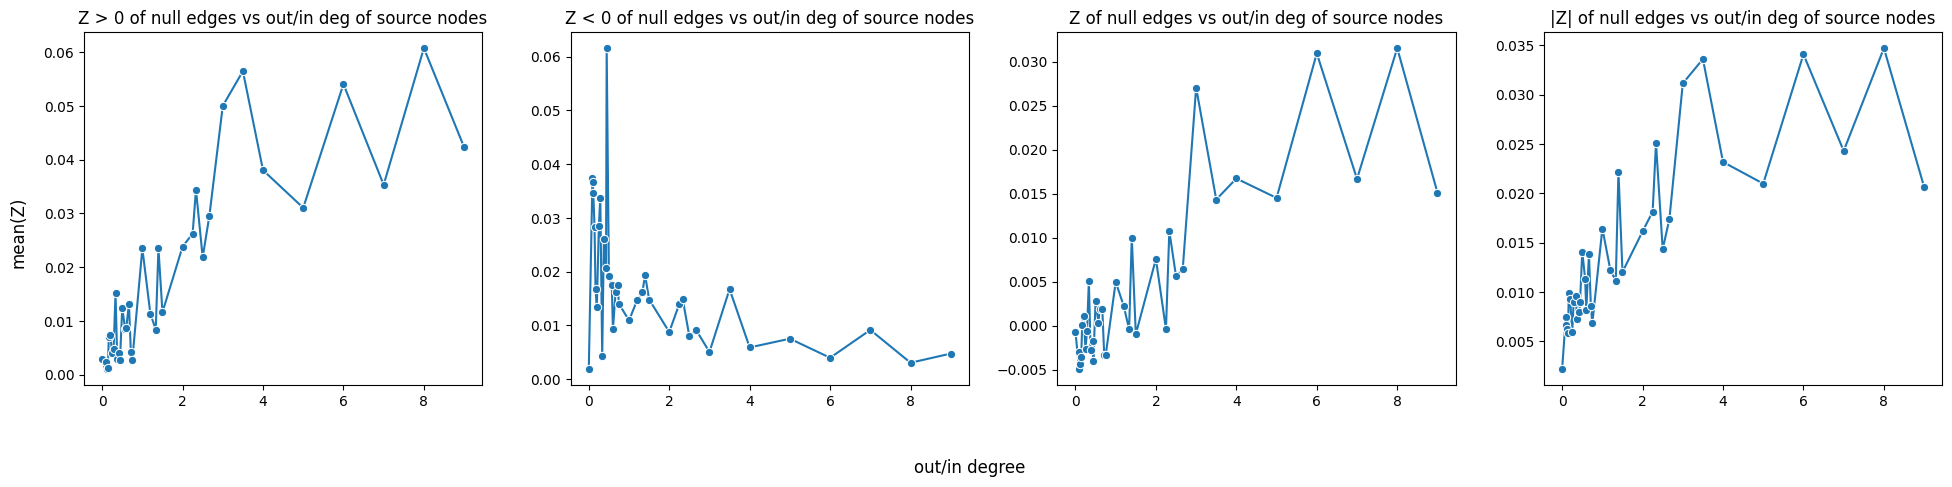

In [198]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
src=True
comb='out/in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb)    


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

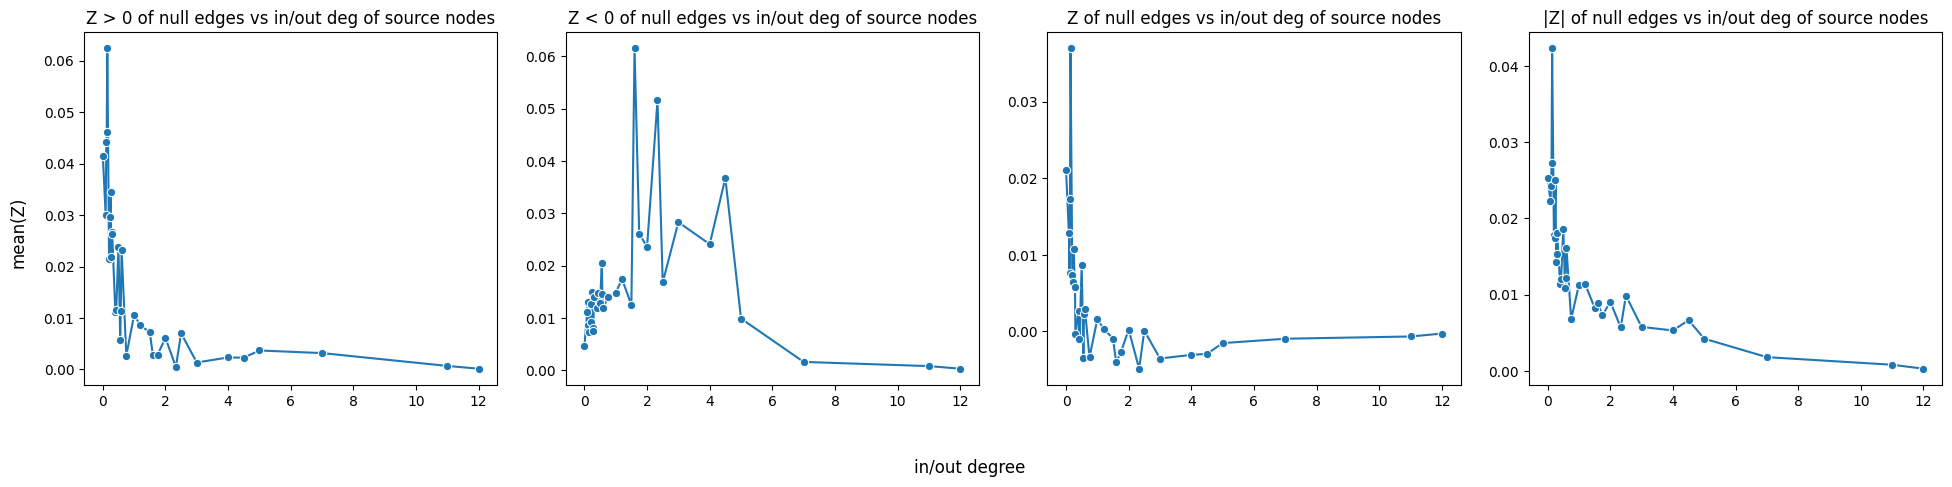

In [199]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
src=True
comb='in/out'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb)    


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

# max(Z_null) vs combine(out-deg, in-deg) of source nodes

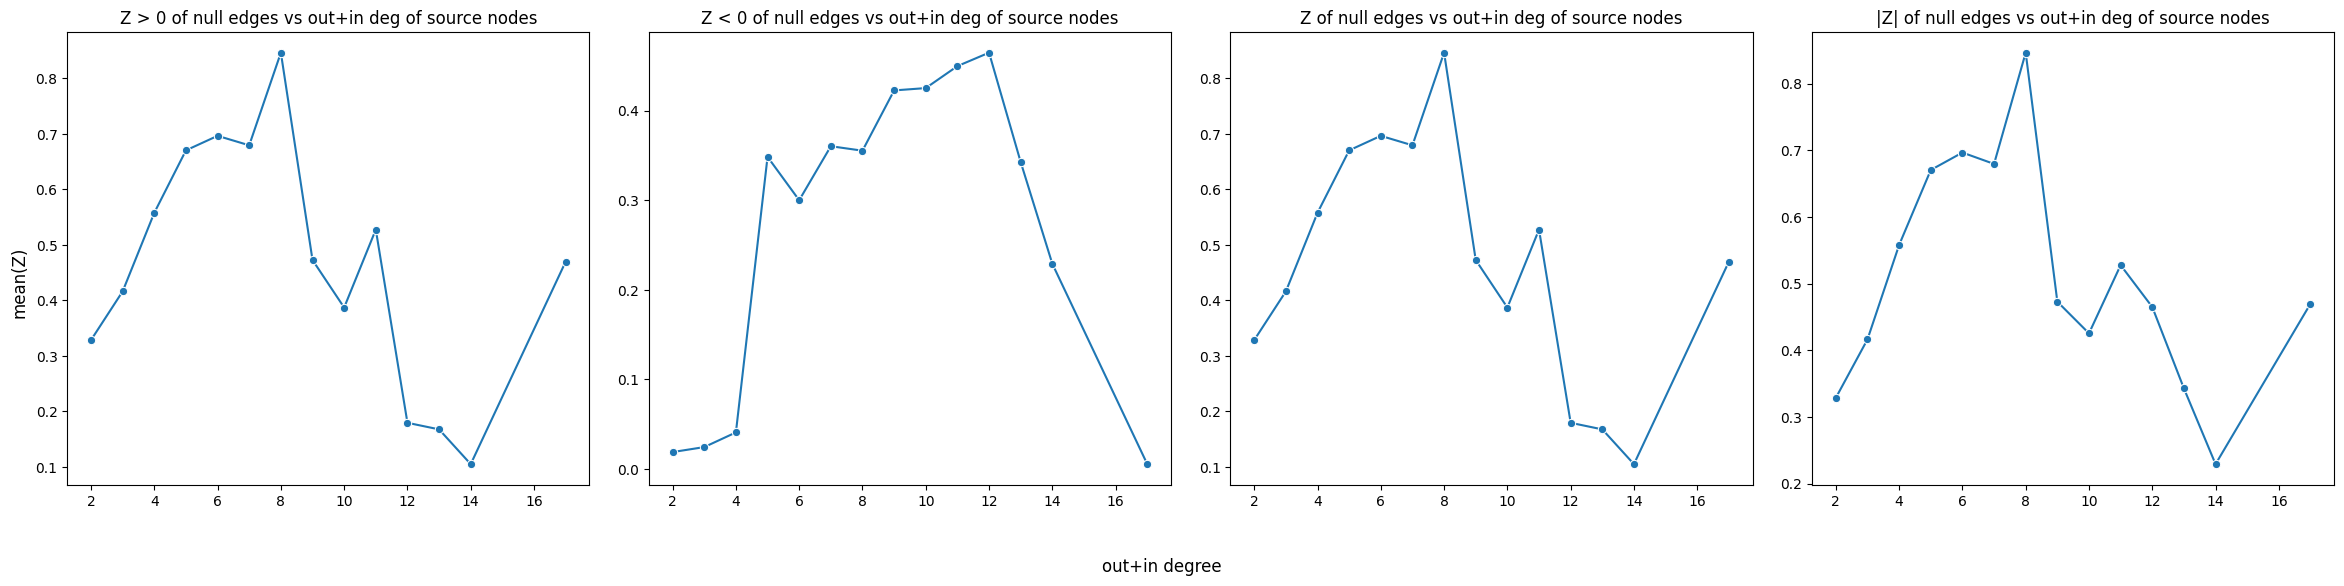

In [190]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
comb='out+in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb, op='max')


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

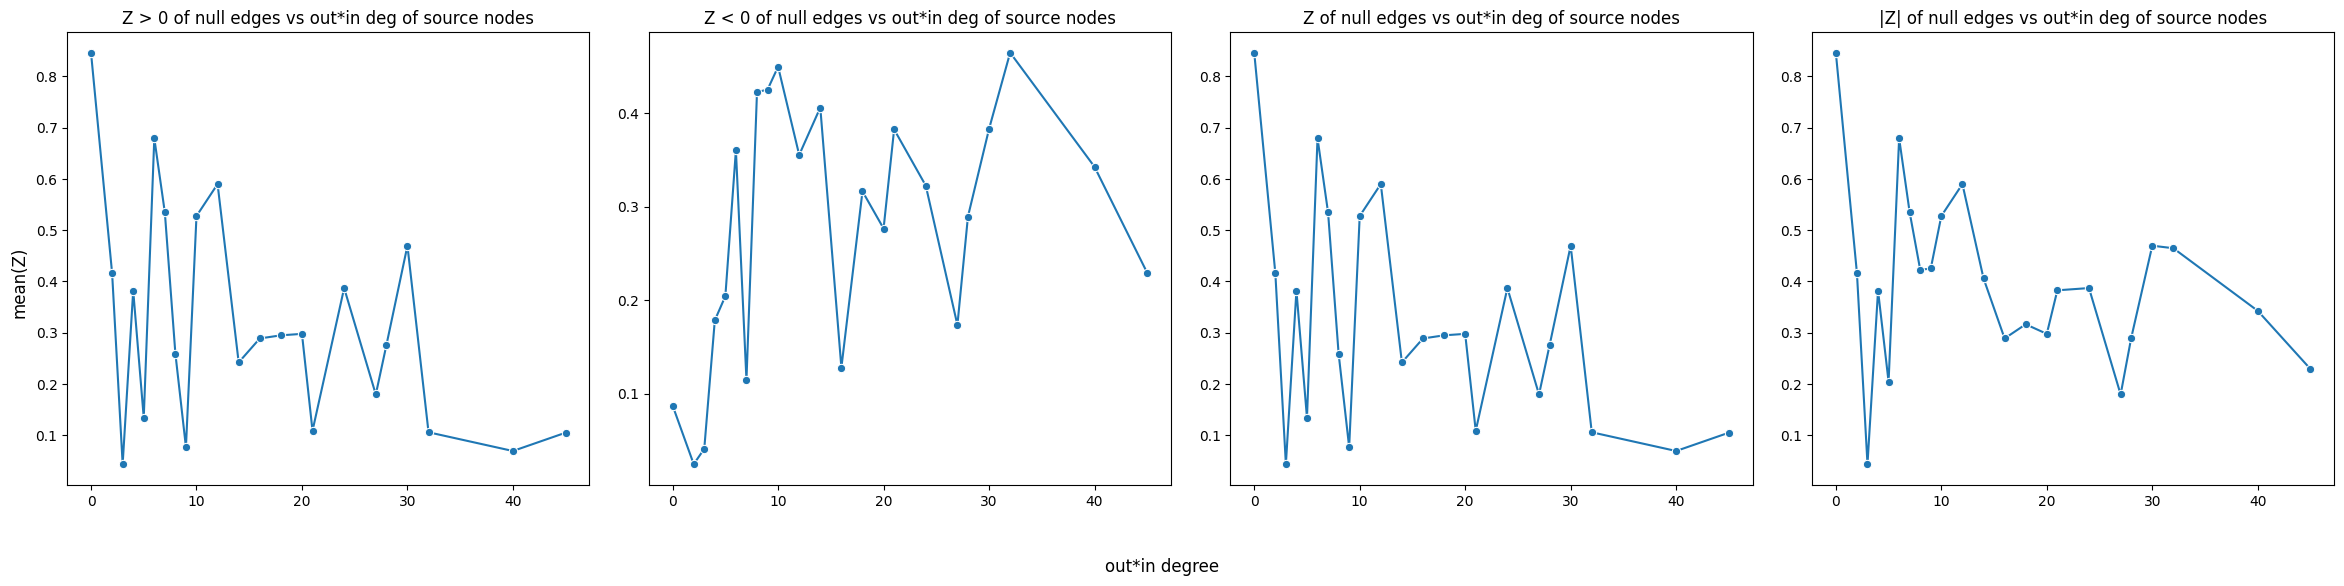

In [191]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
src=True
comb='out*in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb, op='max')    


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

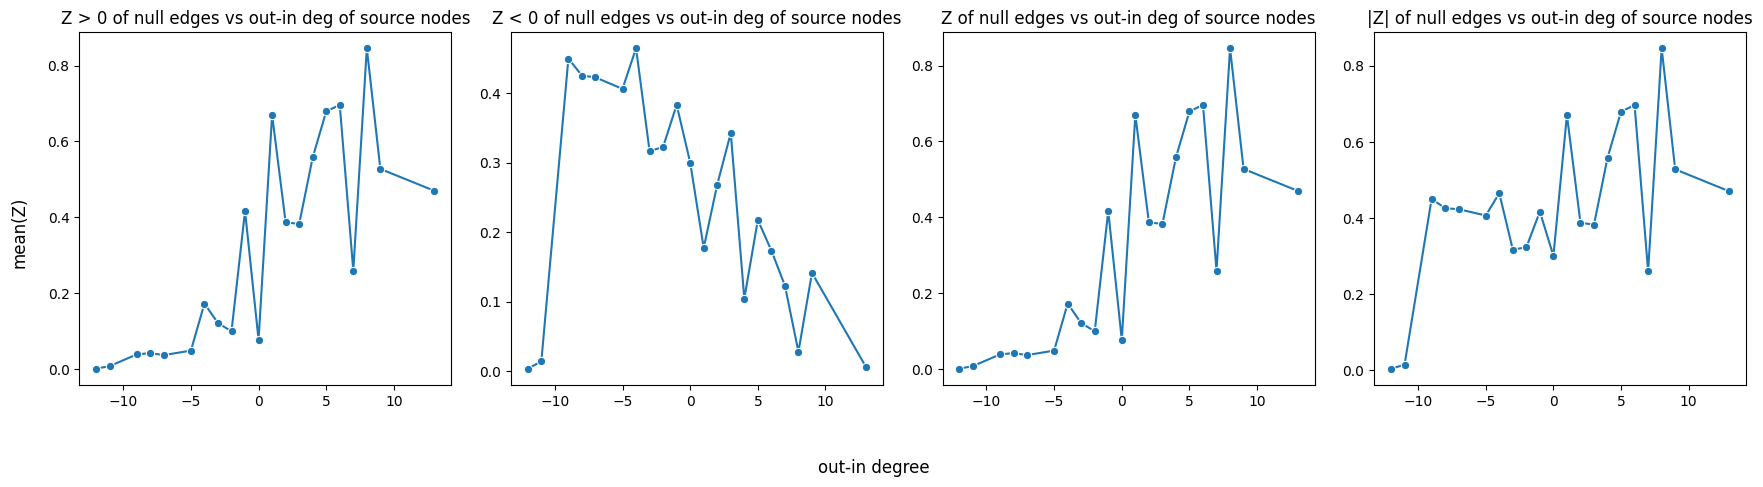

In [202]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
src=True
comb='out-in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb, op='max')    


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

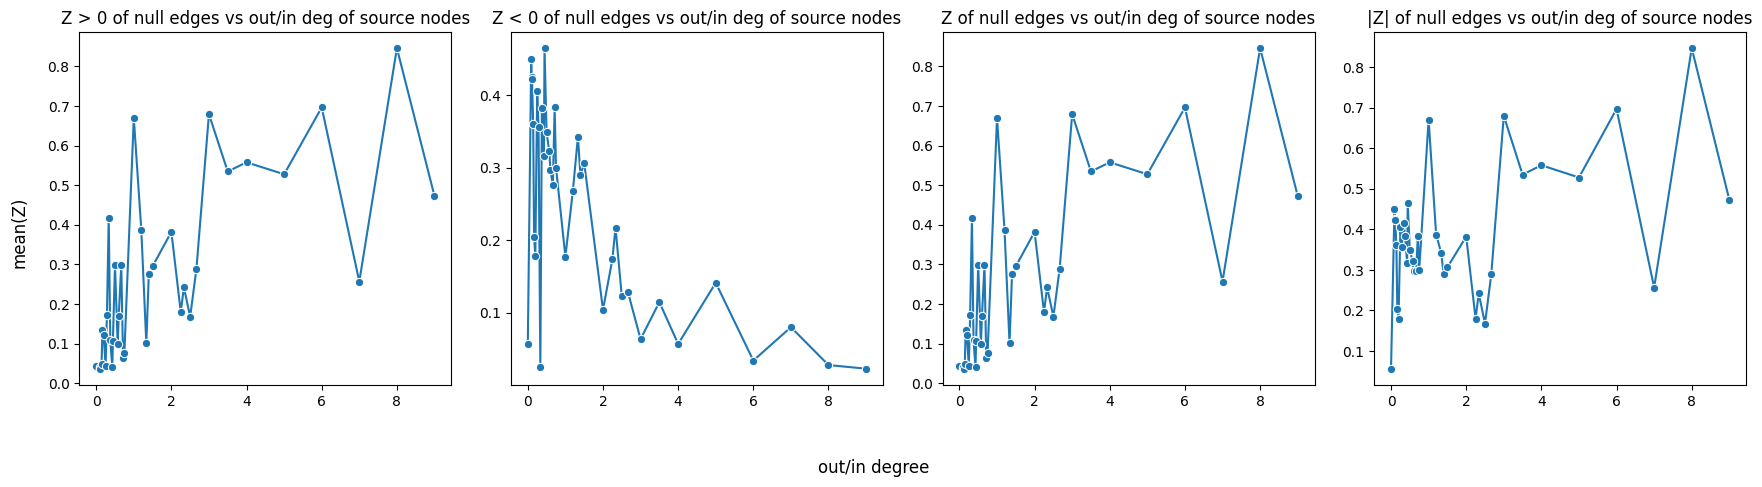

In [201]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
src=True
comb='out/in'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb, op='max') 


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

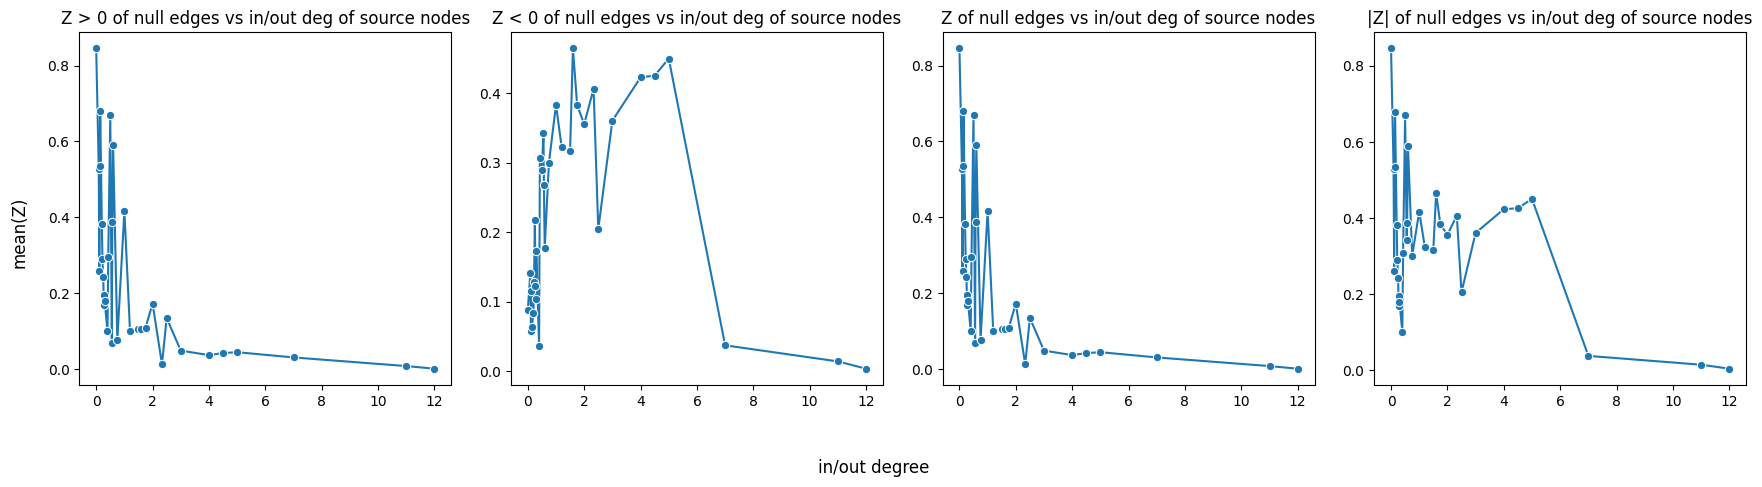

In [200]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
src=True
comb='in/out'

z_option_list = ['>', '<', 'all', 'abs']
for i in range(4):
    z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, axs[i], z_option=z_option_list[i], src=src, comb=comb, op='max')   


fig.supxlabel(f'{comb} degree')
fig.supylabel('mean(Z)')
plt.tight_layout(pad=2)

# transitive effect: |W^2(11)| - |W^2(21)| vs Z
* didn't find any pattern

<Axes: xlabel='Z_pow', ylabel='Z'>

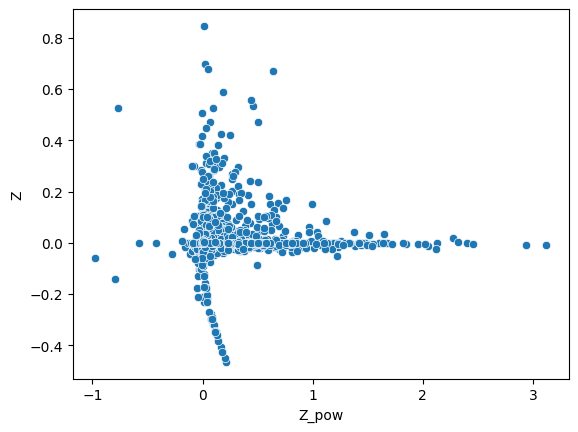

In [348]:
W_est_pow = np.linalg.matrix_power(W_est, 2)
W11_pow, W21_pow = get_block(W_est_pow, n_nodes, index=11), get_block(W_est_pow, n_nodes, index=21)
Z_pow = get_Z(W_est_pow, n_nodes)
# Z_pow = np.abs(W11_pow - W21_pow)
# mask = (Z11_21 > 0.) & (~B_true)
mask = ~B_true
data_dict = {
    'Z_pow': Z_pow[mask],
    'Z': Z11_21[mask]
}
sns.scatterplot(data_dict, x='Z_pow', y='Z')

<Axes: xlabel='Z_pow', ylabel='Z'>

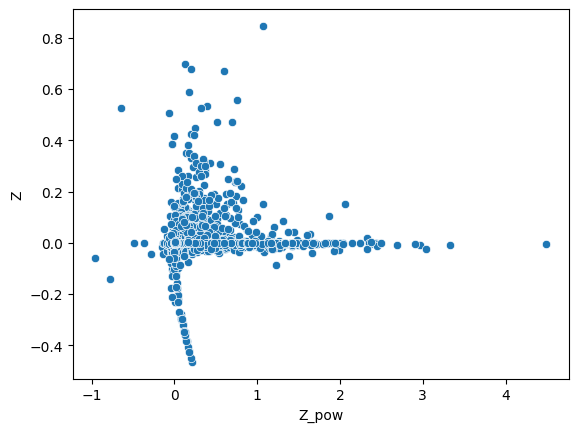

In [349]:
W_est_pow = np.linalg.matrix_power(np.abs(W_est), 2)
W11_pow, W21_pow = get_block(W_est_pow, n_nodes, index=11), get_block(W_est_pow, n_nodes, index=21)
Z_pow = get_Z(W_est_pow, n_nodes)
# Z_pow = np.abs(W11_pow - W21_pow)
# mask = (Z11_21 > 0.) & (~B_true)
mask = ~B_true
data_dict = {
    'Z_pow': Z_pow[mask],
    'Z': Z11_21[mask]
}
sns.scatterplot(data_dict, x='Z_pow', y='Z')

# Z vs depth of source nodes

In [352]:
G = nx.DiGraph(B_true.astype(int))

In [363]:
# take all nodes without in-degree, the start nodes of a DAG
start_nodes = np.where(B_true.sum(axis=0) == 0)[0]

In [364]:
start_nodes

array([10, 11, 15, 21, 23, 25, 32, 34, 55, 56, 65, 71, 72])

In [79]:
def z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_strip=False, alpha=0.5):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"

    data_dict = {
        "min_depth": [],
        "Z": [],
        "label": []
    }
    
    G = nx.DiGraph(B_true.astype(int))
    start_nodes = np.where(B_true.sum(axis=0) == 0)[0]
    
    min_depth = {}
    for n in G.nodes:
        depth = []
        _depth = dict(nx.single_target_shortest_path_length(G, target=n))
        for st_n in start_nodes:
            depth.append(_depth.get(st_n, np.inf))
        depth = np.array(depth)
        min_depth[n] = depth.min()

    min_depth_uni = np.unique(list(min_depth.values()))
    for min_d in min_depth_uni:
        _n_mask = np.where(
            np.array(list(min_depth.values())) == min_d
        )[0]
        n_mask = np.full(len(B_true), fill_value=False)
        n_mask[_n_mask] = True

        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
        
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='min_depth', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='min_depth', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    ax.set_title(f'knockoff statistics Z vs min depth of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    ax.set_xlabel("for each node, min depth from it to all starting nodes")
    ax.set_ylabel("knockoff statistics of edges out of source nodes")
    return df

def sys_z0_vs_depth_box(n_nodes, seed, alpha=0.5):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"v34/v{n_nodes}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_strip=True, alpha=alpha)
    return df

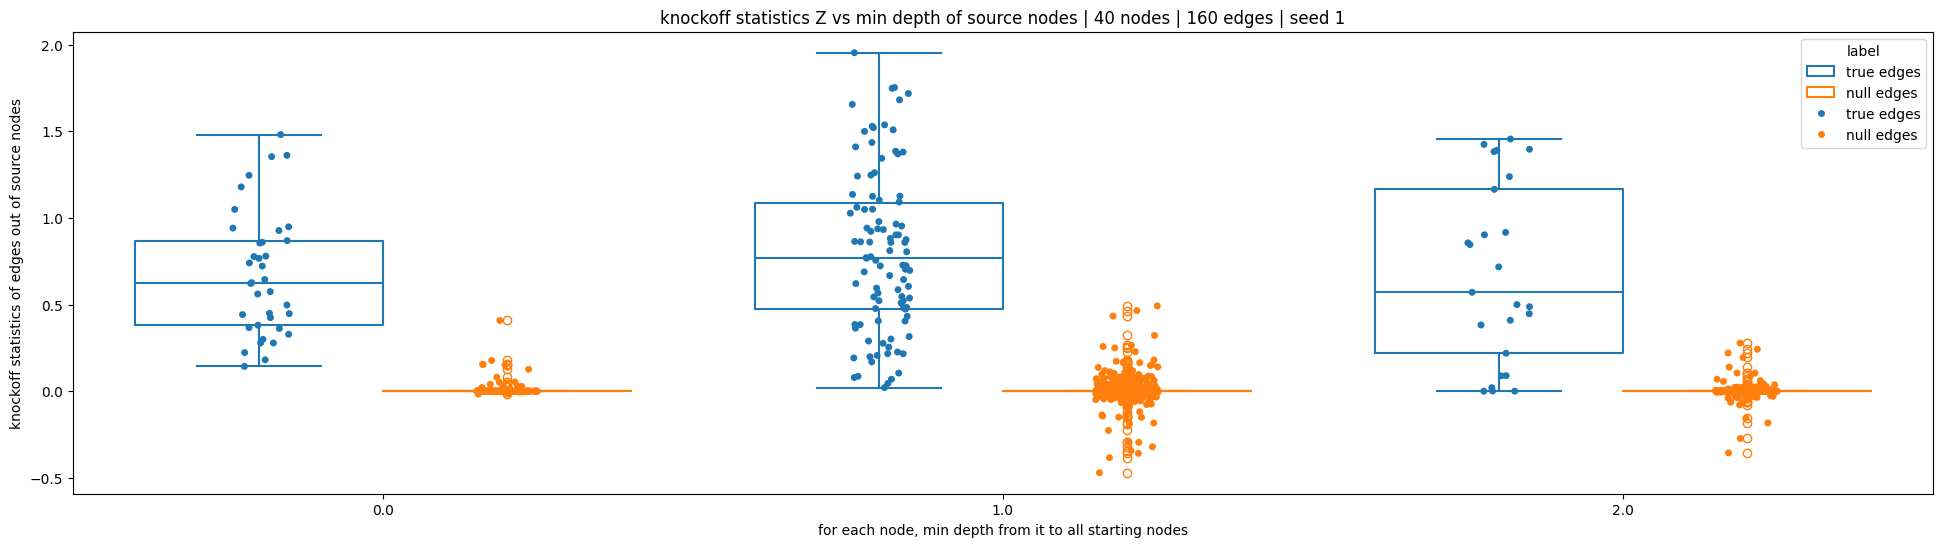

In [81]:
df = sys_z0_vs_depth_box(40, 1, 1)

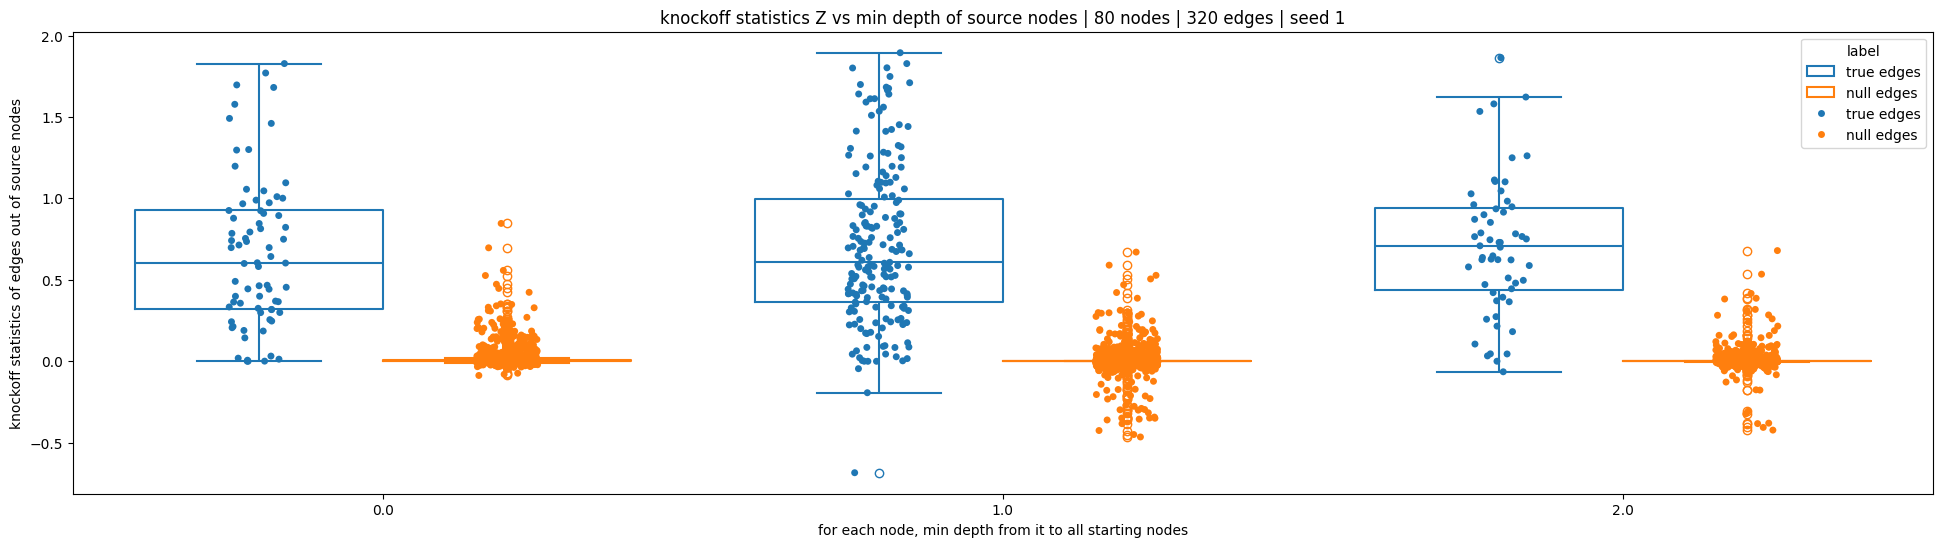

In [82]:
df = sys_z0_vs_depth_box(80, 1, 1)

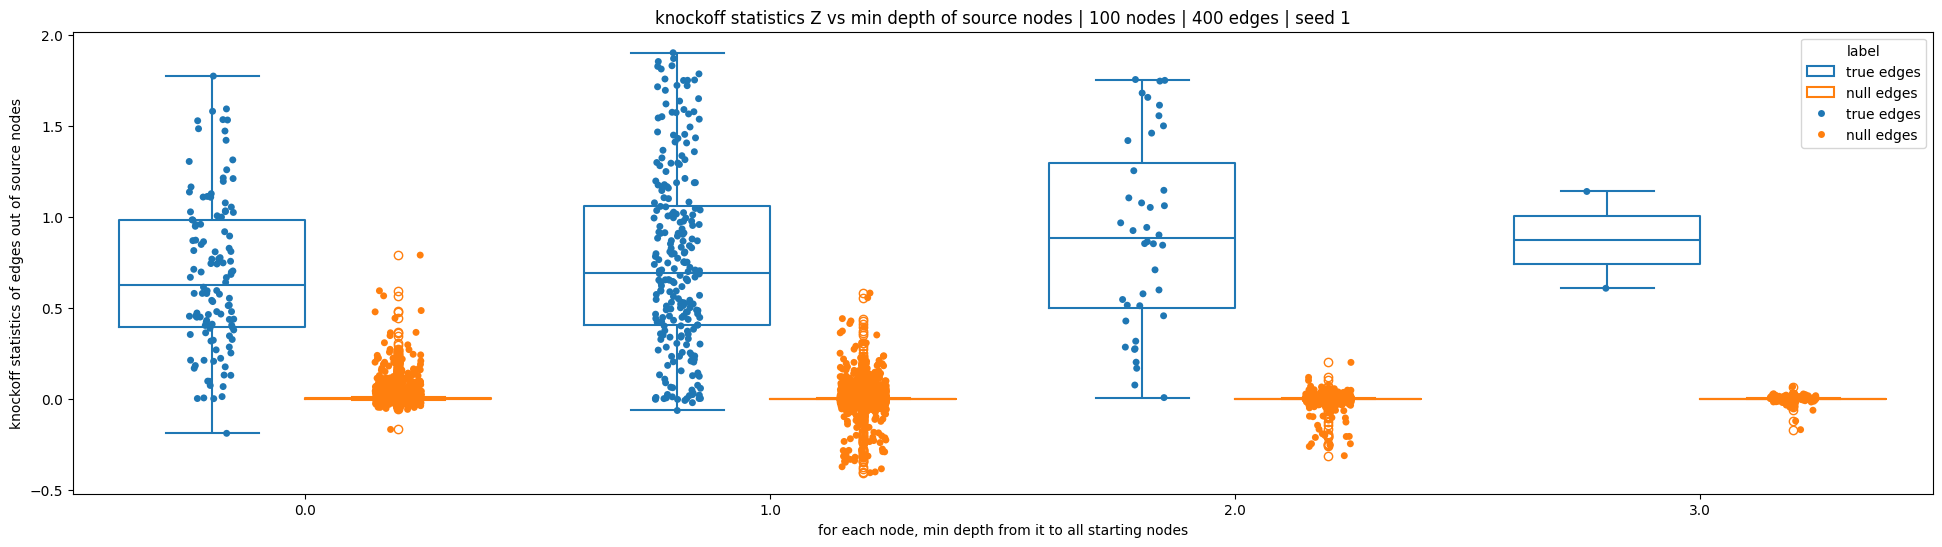

In [83]:
df = sys_z0_vs_depth_box(100, 1, 1)

# Z vs transitivity

In [84]:
n_nodes = 80
X, B_true, W_est, W_true = load_data(n_nodes, 1, "v34/v80")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

In [85]:
G = nx.DiGraph(B_true.astype(int))

In [102]:
res_e = []
for n1 in G.nodes:
    for n2 in G.nodes:
        paths = list(nx.all_simple_edge_paths(G, n1, n2))
        path_lens = [len(path) for path in paths]
        if (2 in path_lens) and ((n1, n2) in G.edges):
            res_e.append((n1, n2))

In [103]:
len(res_e)

75

In [109]:
len(res_e) / G.number_of_edges()

0.234375

In [101]:
(0, 12) in G.edges

True

In [110]:
G.out_edges(2)

OutEdgeDataView([(2, 9), (2, 12), (2, 16), (2, 17), (2, 22), (2, 24), (2, 28), (2, 38), (2, 42), (2, 47), (2, 51), (2, 57), (2, 59), (2, 70), (2, 74)])

In [111]:
G.in_edges(22)

InEdgeDataView([(2, 22), (20, 22), (39, 22), (43, 22), (47, 22), (49, 22), (77, 22)])

In [105]:
res_e

[(0, 41),
 (0, 63),
 (2, 9),
 (2, 16),
 (2, 17),
 (2, 22),
 (2, 38),
 (2, 42),
 (2, 47),
 (2, 57),
 (2, 70),
 (2, 74),
 (4, 26),
 (6, 49),
 (8, 1),
 (8, 61),
 (10, 67),
 (11, 9),
 (11, 58),
 (11, 74),
 (12, 4),
 (12, 45),
 (12, 53),
 (13, 18),
 (13, 44),
 (13, 73),
 (18, 67),
 (20, 22),
 (24, 57),
 (27, 29),
 (27, 41),
 (27, 43),
 (27, 69),
 (32, 47),
 (32, 74),
 (34, 45),
 (36, 38),
 (39, 14),
 (39, 69),
 (42, 58),
 (43, 22),
 (43, 57),
 (46, 37),
 (46, 44),
 (46, 49),
 (46, 57),
 (49, 38),
 (52, 51),
 (52, 73),
 (54, 41),
 (55, 59),
 (55, 73),
 (59, 14),
 (62, 29),
 (62, 67),
 (64, 48),
 (64, 67),
 (65, 26),
 (65, 66),
 (69, 38),
 (69, 41),
 (70, 38),
 (70, 58),
 (70, 75),
 (71, 20),
 (71, 26),
 (71, 39),
 (71, 49),
 (71, 57),
 (79, 9),
 (79, 16),
 (79, 26),
 (79, 38),
 (79, 51),
 (79, 57)]